# 分析概率密度曲线拐点位置

In [2]:
# 常用第三方工具导入

import re
import ast
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from functional import seq
from itertools import product
from loguru import logger
from joblib import Parallel, delayed

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, minimize
from scipy.misc import derivative


from matplotlib.font_manager import FontProperties
from matplotlib import rcParams

config = {
    "font.family": "serif",
    "font.size": 12,
    "mathtext.fontset": "stix",  # matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
    "font.serif": ["STZhongsong"],  # 华文中宋
    "axes.unicode_minus": False  # 处理负号，即-号
}
rcParams.update(config)

In [4]:
# 自定义模块导入

import sys
sys.path.append(".")
sys.path.append("D:\Code\Mine\occupational_health_system_v2")
sys.path.append("D:\Study_and_Work\Mine\之江实验室\PostDoc\\2_课题\Code\Mine\occupational_health_system_v2")

from staff_info import StaffInfo
from utils.data_helper import mark_group_name

In [5]:
# 常量设置

## 路径常量
cache_path = Path("./cache")
models_path = Path("./models")

## 条件常量
age_cut = [15, 30, 40, 60]
# duration_cut = [-1, 7, 11, np.inf]
duration_cut = [-1, 5, 10, np.inf]
key_feature = "LAeq"
initial_guess = [1, 1, 0.1, 80]

In [6]:
# 函数设置
def sigmoid(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

    
# def logistic_func(x, alpha, beta1, beta21, beta22, beta23, phi):
def logistic_func(x, params):
    alpha, beta1, beta21, beta22, beta23, phi = params
    F = alpha + beta1 * x[:, 0] + \
        beta21 * np.power(x[:, 1], phi) + \
        beta22 * np.power(x[:, 2], phi) + \
        beta23 * np.power(x[:, 3], phi)
    return np.exp(F) / (1 + np.exp(F))

In [27]:
def udlr_res_plot(best_params_estimated,
                  best_L_control,
                  max_LAeq,
                  age = 30,
                  LAeq = np.arange(70, 100),
                  duration = np.array([1, 0, 0]),
                  point_type = "2nd"):
    """_summary_
       概率曲线绘制函数

    Args:
        best_params_estimated (_type_): _description_
        best_L_control (_type_): _description_
        max_LAeq (_type_): _description_
        age (int, optional): _description_. Defaults to 30.
        LAeq (_type_, optional): _description_. Defaults to np.arange(70, 100).
        duration (_type_, optional): _description_. Defaults to np.array([1, 0, 0]).
    """
    if duration[0] == 1:
        duration_desp = "= 2~4"
    elif duration[1] == 1:
        duration_desp = "= 5~10"
    elif duration[2] == 1:
        duration_desp = "> 10"
    else:
        raise ValueError
    logger.info(f"Params: {best_params_estimated}")
    logger.info(f"L_control: {best_L_control}")
    logger.info(f"max LAeq: {max_LAeq}")
    
    LAeq_duration_matrix = np.tile(duration, (len(LAeq), 1)) * (
        (LAeq - best_L_control) / (max_LAeq - best_L_control))[:, np.newaxis]
    age_matrix = age * np.ones(len(LAeq))

    plot_X = np.concatenate((age_matrix[:, np.newaxis], LAeq_duration_matrix),
                            axis=1)
    pred_y = logistic_func(x=plot_X, params=best_params_estimated)
    f_prime = np.gradient(pred_y, LAeq)
    f_prime_double = np.gradient(f_prime, LAeq)
    logger.info(f"f prime: {f_prime}")
    logger.info(f"f prime double: {f_prime_double}")
    

    if point_type == "1st":
        point_x = LAeq[np.nanargmax(f_prime)]
    elif point_type == "2nd":
        point_x = LAeq[np.nanargmax(f_prime_double)]
    elif point_type == "2nd_critical":
        f_prime_double_filled_nan = np.nan_to_num(f_prime_double, nan=+0.0)
        logger.info(f"f prime double filled nan: {f_prime_double_filled_nan}")
        diff_arr = np.diff(np.sign(f_prime_double_filled_nan))
        point_x = LAeq[np.where(diff_arr != 0)[0] + 1][0]
        
    age_array = np.array([age])
    point_x_duration_array = (point_x - best_L_control) / (
        max_LAeq - best_L_control) * duration
    point_X = np.concatenate((age_array, point_x_duration_array),
                             axis=0)[np.newaxis, :]
    point_y = logistic_func(x=point_X, params=best_params_estimated)
    fig, ax = plt.subplots(1, figsize=(6.5, 5))
    ax.annotate(f"{point_x} dB",
                xy=(point_x, point_y),
                xytext=(point_x - 5, point_y + 0.001),
                color="red",
                arrowprops=dict(color="red", arrowstyle="->"))
    ax.plot(LAeq, pred_y, alpha=0.4)
    ax.set_title(f"Age = {age}, Duration {duration_desp}")
    ax.set_ylabel("Probability")
    ax.set_xlabel("Sound Level in dB")
    plt.show()

In [24]:
f_prime_double = [-2.67139922e-05,-3.82018944e-05,-4.59294713e-05,-3.83712171e-05,
 -3.07499096e-05, -2.30874579e-05, -1.54009495e-05, -7.70261036e-06,
  2.17686404e-10,  7.70508654e-06,  1.54144461e-05,  2.31356482e-05,
  3.08809568e-05,  3.86675698e-05,  4.65176595e-05,  5.44584366e-05,
  6.25222444e-05,  7.07466885e-05,  7.91748079e-05,  8.78552930e-05,
  9.68427550e-05,  1.06198052e-04,  1.15988674e-04,  1.26289193e-04,
  1.37181775e-04,  1.48756758e-04,  1.61113287e-04,  1.74360009e-04,
  1.37693008e-04,  9.41659010e-05,]
f_prime_double = [ 0. ,         0.,          0.,          0.,          0.,          0.0003815,
  0.00065485,  0.00096912,  0.00131506,  0.00168521,  0.00207145,  0.00246317,
  0.00284508,  0.0031945,   0.00347843,  0.003651,    0.00365306,  0.00341642,
  0.00287588,  0.00199087,  0.00077413, -0.00068278, -0.00220386, -0.00355793,
 -0.00452199, -0.00495446, -0.00484145, -0.00429187, -0.00283923, -0.00175029,]
diff_arr = np.diff(np.sign(f_prime_double))
# [np.where(diff_arr != 0)[0] + 1][0]
diff_arr

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

# 对照组数据加载

## 中国对照组数据

In [5]:
# Step 1
## 加载对照组数据
China_control_group_df = pd.read_csv(cache_path/"Chinese_extract_control_classifier_df.csv", header=0)

## 对年龄、工龄进行分组
China_control_group_df["age_box"] = China_control_group_df["age"].apply(
            lambda x: mark_group_name(x, qcut_set=age_cut, prefix="A-"))
China_control_group_df["duration_box"] = China_control_group_df["duration"].apply(
            lambda x: mark_group_name(x, qcut_set=duration_cut, prefix="D-"))


In [6]:
# Step 2
## 统计各个分组出现听力损伤的概率
China_total_num = China_control_group_df.groupby(["sex", "age_box"])["HL1234_Y"].count()
China_confirmed_num = China_control_group_df.groupby(["sex", "age_box"])["HL1234_Y"].sum()

China_control_group_base_prob = pd.DataFrame(China_confirmed_num / China_total_num)

In [7]:
China_control_group_df.groupby(["sex", "age_box", "duration_box"])["HL1234_Y"].count()

sex  age_box  duration_box
F    A-1      D-1             248
              D-2              50
              D-3               3
     A-2      D-1              48
              D-2             138
              D-3             138
     A-3      D-1              16
              D-2              23
              D-3             280
M    A-1      D-1             109
              D-2              14
     A-2      D-1              28
              D-2              75
              D-3              93
     A-3      D-1              10
              D-2              11
              D-3             236
Name: HL1234_Y, dtype: int64

In [8]:
China_control_group_base_prob

HL1234_Y
sex age_box          
F   A-1      0.000000
    A-2      0.000000
    A-3      0.015674
M   A-1      0.000000
    A-2      0.000000
    A-3      0.035019

## NOISH对照组数据

In [9]:
# Step 1
## 加载对照组数据
NOISH_control_group_df = pd.read_csv(cache_path/"NOISH_extract_control_classifier_df.csv", header=0)


## 对年龄、工龄进行分组
NOISH_control_group_df["age_box"] = NOISH_control_group_df["age"].apply(
            lambda x: mark_group_name(x, qcut_set=age_cut, prefix="A-"))
NOISH_control_group_df["duration_box"] = NOISH_control_group_df["duration"].apply(
            lambda x: mark_group_name(x, qcut_set=duration_cut, prefix="D-"))

In [10]:
# Step 2
## 统计各个分组出现听力损伤的概率
NOISH_total_num = NOISH_control_group_df.groupby(["sex", "age_box"])["HL1234_Y"].count()
NOISH_confirmed_num = NOISH_control_group_df.groupby(["sex", "age_box"])["HL1234_Y"].sum()

NOISH_control_group_base_prob = pd.DataFrame(NOISH_confirmed_num / NOISH_total_num)

In [13]:
# Step 3 
## 统计各个年龄下出现听力损伤的概率
NOISH_total_num_age = NOISH_control_group_df.groupby(["sex", "age"])["HL1234_Y"].count()
NOISH_confirmed_num_age = NOISH_control_group_df.groupby(["sex", "age"])["HL1234_Y"].sum()

NOISH_control_group_age_base_prob = pd.DataFrame(NOISH_confirmed_num_age / NOISH_total_num_age)

In [14]:
NOISH_control_group_base_prob

HL1234_Y
sex age_box          
M   A-1      0.036496
    A-2      0.088235
    A-3      0.259843

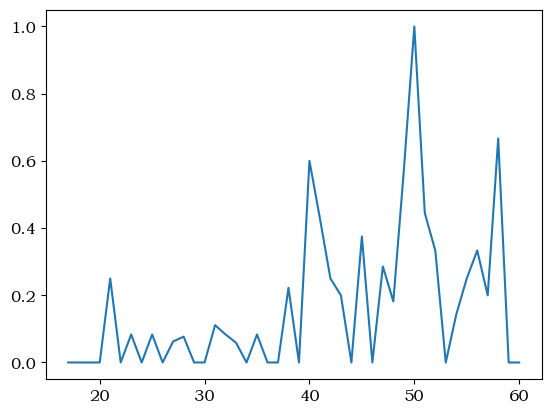

In [29]:
plt.plot(NOISH_control_group_age_base_prob.index.get_level_values("age"),NOISH_control_group_age_base_prob["HL1234_Y"])
plt.show()

In [125]:
NOISH_control_group_df.age.min()

17

# 实验组数据加载

## 中国实验组数据

### 中国实验组原始数据加载

In [30]:
# Step 0
## 加载实验组原始数据
China_experiment_group_df = pd.read_csv(cache_path/f"Chinese_extract_classifier_df.csv", header=0)

## 对年龄、工龄进行分组
China_experiment_group_df["age_box"] = China_experiment_group_df["age"].apply(
            lambda x: mark_group_name(x, qcut_set=age_cut, prefix="A-"))
China_experiment_group_df["duration_box"] = China_experiment_group_df["duration"].apply(
            lambda x: mark_group_name(x, qcut_set=duration_cut, prefix="D-"))
China_experiment_group_df.age_box.value_counts()

A-2    1697
A-3    1677
A-1    1337
Name: age_box, dtype: int64

In [31]:
China_experiment_group_df.groupby(["sex"])["HL1234_Y"].count()

sex
F    1081
M    3630
Name: HL1234_Y, dtype: int64

In [32]:
China_experiment_group_df.groupby(["sex", "age_box", "duration_box"])["HL1234_Y"].count()

sex  age_box  duration_box
F    A-1      D-1             129
              D-2              27
     A-2      D-1             145
              D-2             111
              D-3             188
     A-3      D-1              79
              D-2             118
              D-3             284
M    A-1      D-1             914
              D-2             243
              D-3              24
     A-2      D-1             402
              D-2             333
              D-3             518
     A-3      D-1             219
              D-2             297
              D-3             680
Name: HL1234_Y, dtype: int64

In [33]:
China_experiment_group_df.LAeq.value_counts()

58.619860    48
69.417489    14
62.913553     7
82.017200     3
84.966820     3
             ..
81.912551     1
81.699631     1
87.651738     1
81.030632     1
97.463348     1
Name: LAeq, Length: 4633, dtype: int64

### 自定义LR分类模型参数加载

2024-03-26 00:12:35.986 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-26 00:12:35.987 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-26 00:12:35.988 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-26 00:12:35.990 | INFO     | __main__:udlr_res_plot:40 - f prime: [2.16010334e-04 1.89296342e-04 1.39606545e-04 9.74373995e-05
 6.28641113e-05 3.59375803e-05 1.66891955e-05 5.13568123e-06
 1.28397473e-06 5.13611660e-06 1.66941478e-05 3.59650088e-05
 6.29654443e-05 9.77269224e-05 1.40300584e-04 1.90762241e-04
 2.49217457e-04 3.15806730e-04 3.90710834e-04 4.74156346e-04
 5.66421420e-04 6.67841856e-04 7.78817524e-04 8.99819203e-04
 1.03139591e-03 1.17418275e-03 1.32890942e-03 1.49640933e-03
 1.67762944e-03 1.77179534e-03]
2024-03-26 00:12:35.993 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-2.67139922e-05 -3.82018944e-05 -4.59294713e-05 -3.83712171e-05
 

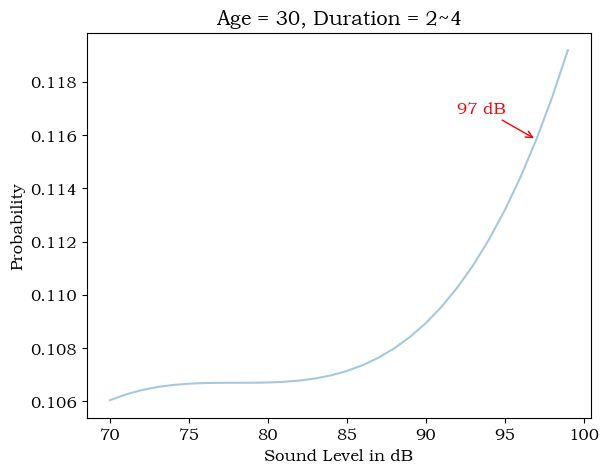

2024-03-26 00:12:36.115 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-26 00:12:36.116 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-26 00:12:36.116 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-26 00:12:36.117 | INFO     | __main__:udlr_res_plot:40 - f prime: [3.51406338e-04 3.08079341e-04 2.27407501e-04 1.58817455e-04
 1.02508871e-04 5.86170266e-05 2.72254015e-05 8.37849494e-06
 2.09476858e-06 8.37965377e-06 2.72385832e-05 5.86900330e-05
 1.02778589e-04 1.59588078e-04 2.29254823e-04 3.11981122e-04
 4.08049065e-04 5.17834823e-04 6.41823589e-04 7.80625341e-04
 9.34991649e-04 1.10583375e-03 1.29424209e-03 1.50150767e-03
 1.72914526e-03 1.97891884e-03 2.25286931e-03 2.55334464e-03
 2.88303226e-03 3.05553734e-03]
2024-03-26 00:12:36.118 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-4.33269967e-05 -6.19994186e-05 -7.46309431e-05 -6.24493148e-05
 

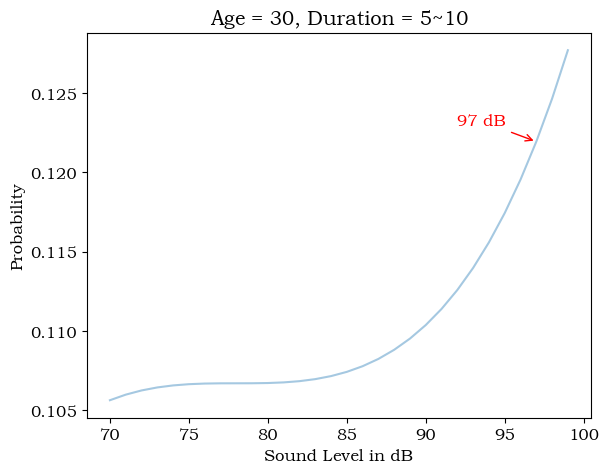

2024-03-26 00:12:36.225 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-26 00:12:36.226 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-26 00:12:36.226 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-26 00:12:36.226 | INFO     | __main__:udlr_res_plot:40 - f prime: [1.37463813e-03 1.20917709e-03 8.98629975e-04 6.30667769e-04
 4.08421628e-04 2.34030785e-04 1.08822628e-04 3.35070494e-05
 8.37907972e-06 3.35255907e-05 1.09033536e-04 2.35198888e-04
 4.12737117e-04 6.42997699e-04 9.28186816e-04 1.27160398e-03
 1.67789976e-03 2.15336306e-03 2.70624706e-03 3.34714296e-03
 4.08940886e-03 4.94965690e-03 5.94829284e-03 7.11008555e-03
 8.46471519e-03 1.00472006e-02 1.18980296e-02 1.40626990e-02
 1.65902004e-02 1.79509335e-02]
2024-03-26 00:12:36.227 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-1.65461044e-04 -2.38004079e-04 -2.89254660e-04 -2.45104173e-04
 

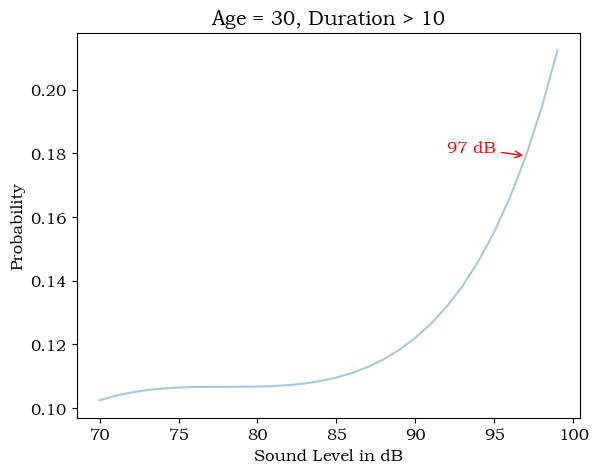

2024-03-26 00:12:36.325 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-26 00:12:36.326 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-26 00:12:36.326 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-26 00:12:36.327 | INFO     | __main__:udlr_res_plot:40 - f prime: [4.38407221e-04 3.84087942e-04 2.83112789e-04 1.97519276e-04
 1.27400407e-04 7.28189609e-05 3.38135850e-05 1.04048487e-05
 2.60127905e-06 1.04053837e-05 3.38196701e-05 7.28526628e-05
 1.27524916e-04 1.97875018e-04 2.83965565e-04 3.85889109e-04
 5.03774031e-04 6.37790332e-04 7.88155297e-04 9.55138985e-04
 1.13906949e-03 1.34033792e-03 1.55940292e-03 1.79679480e-03
 2.05311889e-03 2.32905816e-03 2.62537473e-03 2.94291011e-03
 3.28258368e-03 3.45807474e-03]
2024-03-26 00:12:36.327 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-5.43192799e-05 -7.76472161e-05 -9.32843328e-05 -7.78561913e-05
 

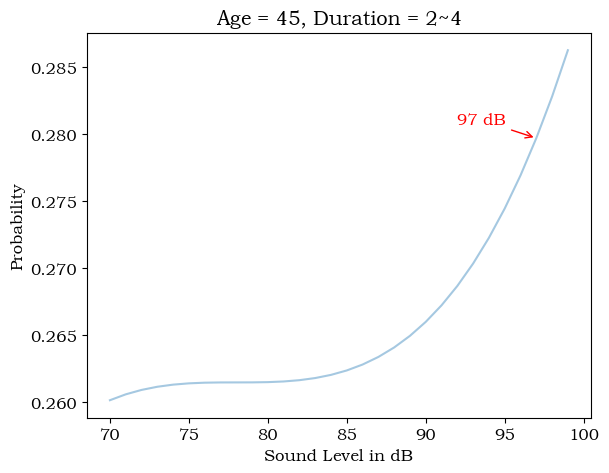

2024-03-26 00:12:36.436 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-26 00:12:36.436 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-26 00:12:36.437 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-26 00:12:36.437 | INFO     | __main__:udlr_res_plot:40 - f prime: [7.14001615e-04 6.25698770e-04 4.61450615e-04 3.22063719e-04
 2.07786004e-04 1.18784718e-04 5.51627762e-05 1.69749419e-05
 4.24391346e-06 1.69763658e-05 5.51789728e-05 1.18874422e-04
 2.08117411e-04 3.23010596e-04 4.63720439e-04 6.30492889e-04
 8.23668778e-04 1.04369882e-03 1.29115803e-03 1.56675929e-03
 1.87136587e-03 2.20600237e-03 2.57186368e-03 2.97032121e-03
 3.40292555e-03 3.87140449e-03 4.37765490e-03 4.92372676e-03
 5.51179711e-03 5.81661099e-03]
2024-03-26 00:12:36.438 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-8.83028456e-05 -1.26275500e-04 -1.51817525e-04 -1.26832306e-04
 

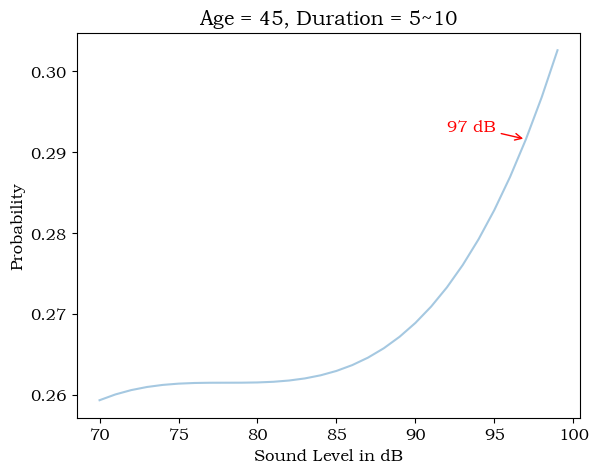

2024-03-26 00:12:36.530 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-26 00:12:36.531 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-26 00:12:36.531 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-26 00:12:36.531 | INFO     | __main__:udlr_res_plot:40 - f prime: [2.81714242e-03 2.47383949e-03 1.83212418e-03 1.28255879e-03
 8.29152993e-04 4.74600527e-04 2.20554035e-04 6.78912671e-05
 1.69756648e-05 6.79140492e-05 2.20813181e-04 4.76035792e-04
 8.34455448e-04 1.29770822e-03 1.86843755e-03 2.55052665e-03
 3.34930941e-03 4.27174634e-03 5.32654472e-03 6.52419161e-03
 7.87685347e-03 9.39807522e-03 1.11021854e-02 1.30032807e-02
 1.51136301e-02 1.74413072e-02 1.99868545e-02 2.27388267e-02
 2.56681958e-02 2.71723103e-02]
2024-03-26 00:12:36.533 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-3.43302930e-04 -4.92509121e-04 -5.95640351e-04 -5.01485592e-04
 

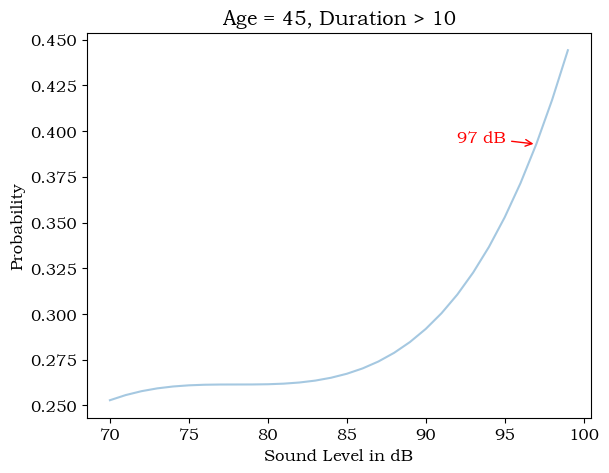

2024-03-26 00:12:36.656 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-26 00:12:36.657 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-26 00:12:36.657 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-26 00:12:36.658 | INFO     | __main__:udlr_res_plot:40 - f prime: [5.46473895e-04 4.78486973e-04 3.52275565e-04 2.45560793e-04
 1.58294573e-04 9.04441985e-05 4.19894333e-05 1.29194736e-05
 3.22983318e-06 1.29191918e-05 4.19862284e-05 9.04264482e-05
 1.58228996e-04 2.45373430e-04 3.51826422e-04 4.77538329e-04
 6.22439559e-04 7.86436661e-04 9.69408039e-04 1.17119918e-03
 1.39161727e-03 1.63042510e-03 1.88733410e-03 2.16199640e-03
 2.45399577e-03 2.76283738e-03 3.08793616e-03 3.42860390e-03
 3.78403489e-03 3.96533266e-03]
2024-03-26 00:12:36.659 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-6.79869224e-05 -9.70991650e-05 -1.16463090e-04 -9.69904961e-05
 

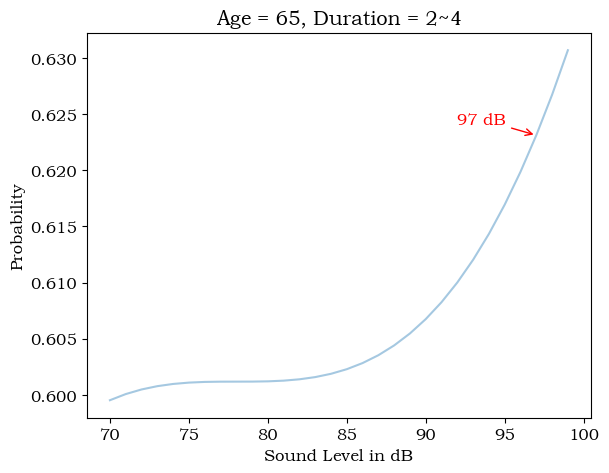

2024-03-26 00:12:36.756 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-26 00:12:36.756 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-26 00:12:36.756 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-26 00:12:36.757 | INFO     | __main__:udlr_res_plot:40 - f prime: [8.92201165e-04 7.81119444e-04 5.74956783e-04 4.00721456e-04
 2.58286802e-04 1.47566289e-04 6.85062269e-05 2.10779021e-05
 5.26938181e-06 2.10771522e-05 6.84976964e-05 1.47519043e-04
 2.58112255e-04 4.00222752e-04 5.73761307e-04 7.78594476e-04
 1.01453418e-03 1.28132605e-03 1.57863622e-03 1.90603599e-03
 2.26298405e-03 2.64880565e-03 3.06266832e-03 3.50355384e-03
 3.97022589e-03 4.46119354e-03 4.97467033e-03 5.50852953e-03
 6.06025608e-03 6.34024599e-03]
2024-03-26 00:12:36.758 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-1.11081722e-04 -1.58622191e-04 -1.90198994e-04 -1.58334990e-04
 

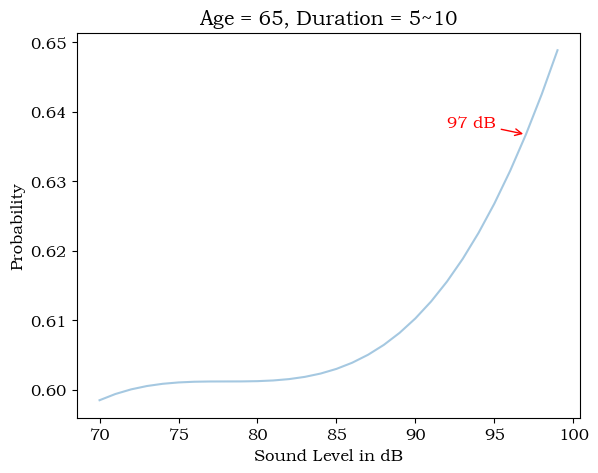

2024-03-26 00:12:36.854 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-26 00:12:36.855 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-26 00:12:36.855 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-26 00:12:36.856 | INFO     | __main__:udlr_res_plot:40 - f prime: [3.58806503e-03 3.13892982e-03 2.30678573e-03 1.60582407e-03
 1.03418434e-03 5.90547549e-04 2.74076157e-04 8.43161594e-05
 2.10775407e-05 8.43041605e-05 2.73939669e-04 5.89791618e-04
 1.03139164e-03 1.59784526e-03 2.28766097e-03 3.09854441e-03
 4.02714071e-03 5.06870669e-03 6.21669519e-03 7.46223796e-03
 8.79352221e-03 1.01950715e-02 1.16469649e-02 1.31240626e-02
 1.45953480e-02 1.60235448e-02 1.73652184e-02 1.85715963e-02
 1.95903405e-02 2.00461110e-02]
2024-03-26 00:12:36.857 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-4.49135209e-04 -6.40639650e-04 -7.66552872e-04 -6.36300694e-04
 

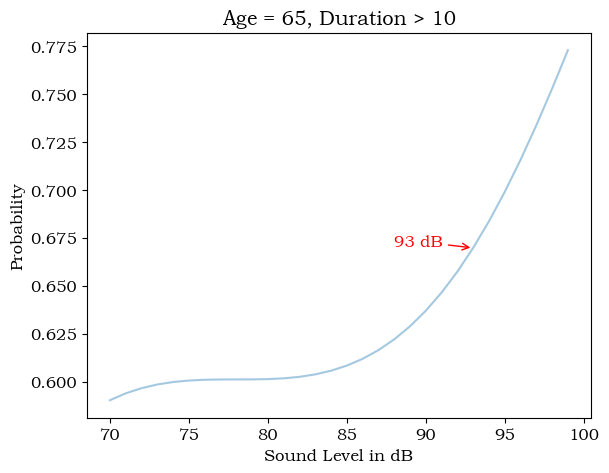

In [31]:
China_udlr_model = pickle.load(open(models_path / f"Chinese_experiment_group_udlr-_classifier_model.pkl", "rb"))

best_params_estimated = China_udlr_model[0]
best_L_control = China_udlr_model[1]
max_LAeq = China_udlr_model[2]

point_type = "2nd"

udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)


udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)


udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)

2024-03-25 23:48:59.777 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-25 23:48:59.777 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-25 23:48:59.779 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-25 23:48:59.781 | INFO     | __main__:udlr_res_plot:40 - f prime: [2.16010334e-04 1.89296342e-04 1.39606545e-04 9.74373995e-05
 6.28641113e-05 3.59375803e-05 1.66891955e-05 5.13568123e-06
 1.28397473e-06 5.13611660e-06 1.66941478e-05 3.59650088e-05
 6.29654443e-05 9.77269224e-05 1.40300584e-04 1.90762241e-04
 2.49217457e-04 3.15806730e-04 3.90710834e-04 4.74156346e-04
 5.66421420e-04 6.67841856e-04 7.78817524e-04 8.99819203e-04
 1.03139591e-03 1.17418275e-03 1.32890942e-03 1.49640933e-03
 1.67762944e-03 1.77179534e-03]
2024-03-25 23:48:59.784 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-2.67139922e-05 -3.82018944e-05 -4.59294713e-05 -3.83712171e-05
 

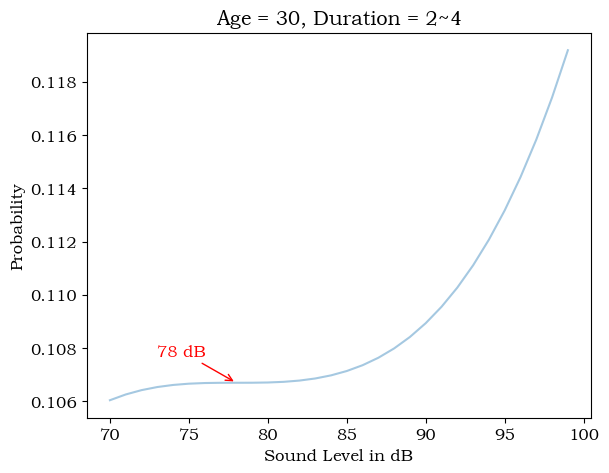

2024-03-25 23:48:59.911 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-25 23:48:59.911 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-25 23:48:59.912 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-25 23:48:59.913 | INFO     | __main__:udlr_res_plot:40 - f prime: [3.51406338e-04 3.08079341e-04 2.27407501e-04 1.58817455e-04
 1.02508871e-04 5.86170266e-05 2.72254015e-05 8.37849494e-06
 2.09476858e-06 8.37965377e-06 2.72385832e-05 5.86900330e-05
 1.02778589e-04 1.59588078e-04 2.29254823e-04 3.11981122e-04
 4.08049065e-04 5.17834823e-04 6.41823589e-04 7.80625341e-04
 9.34991649e-04 1.10583375e-03 1.29424209e-03 1.50150767e-03
 1.72914526e-03 1.97891884e-03 2.25286931e-03 2.55334464e-03
 2.88303226e-03 3.05553734e-03]
2024-03-25 23:48:59.913 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-4.33269967e-05 -6.19994186e-05 -7.46309431e-05 -6.24493148e-05
 

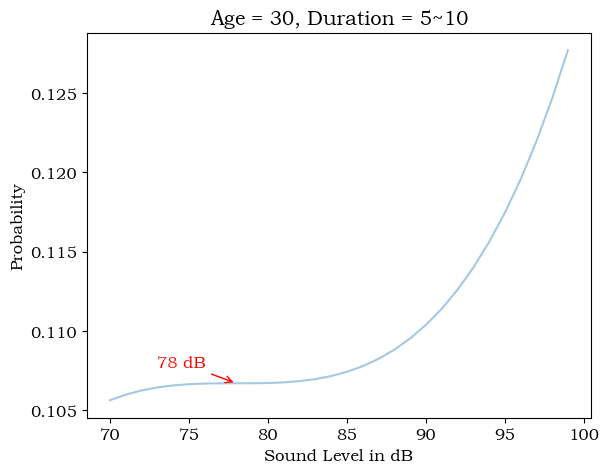

2024-03-25 23:49:00.133 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-25 23:49:00.134 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-25 23:49:00.134 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-25 23:49:00.135 | INFO     | __main__:udlr_res_plot:40 - f prime: [1.37463813e-03 1.20917709e-03 8.98629975e-04 6.30667769e-04
 4.08421628e-04 2.34030785e-04 1.08822628e-04 3.35070494e-05
 8.37907972e-06 3.35255907e-05 1.09033536e-04 2.35198888e-04
 4.12737117e-04 6.42997699e-04 9.28186816e-04 1.27160398e-03
 1.67789976e-03 2.15336306e-03 2.70624706e-03 3.34714296e-03
 4.08940886e-03 4.94965690e-03 5.94829284e-03 7.11008555e-03
 8.46471519e-03 1.00472006e-02 1.18980296e-02 1.40626990e-02
 1.65902004e-02 1.79509335e-02]
2024-03-25 23:49:00.136 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-1.65461044e-04 -2.38004079e-04 -2.89254660e-04 -2.45104173e-04
 

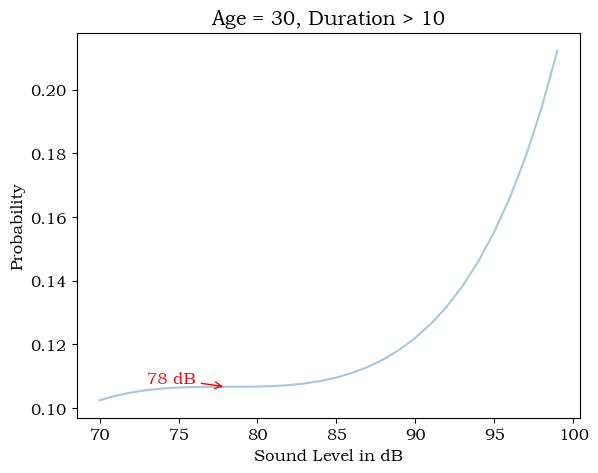

2024-03-25 23:49:00.240 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-25 23:49:00.240 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-25 23:49:00.241 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-25 23:49:00.242 | INFO     | __main__:udlr_res_plot:40 - f prime: [4.38407221e-04 3.84087942e-04 2.83112789e-04 1.97519276e-04
 1.27400407e-04 7.28189609e-05 3.38135850e-05 1.04048487e-05
 2.60127905e-06 1.04053837e-05 3.38196701e-05 7.28526628e-05
 1.27524916e-04 1.97875018e-04 2.83965565e-04 3.85889109e-04
 5.03774031e-04 6.37790332e-04 7.88155297e-04 9.55138985e-04
 1.13906949e-03 1.34033792e-03 1.55940292e-03 1.79679480e-03
 2.05311889e-03 2.32905816e-03 2.62537473e-03 2.94291011e-03
 3.28258368e-03 3.45807474e-03]
2024-03-25 23:49:00.243 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-5.43192799e-05 -7.76472161e-05 -9.32843328e-05 -7.78561913e-05
 

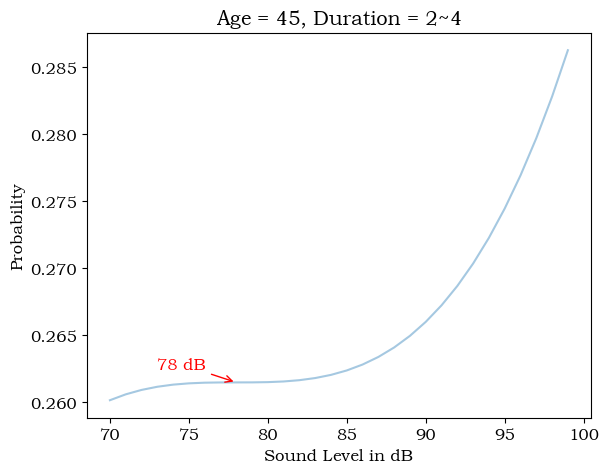

2024-03-25 23:49:00.343 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-25 23:49:00.344 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-25 23:49:00.344 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-25 23:49:00.345 | INFO     | __main__:udlr_res_plot:40 - f prime: [7.14001615e-04 6.25698770e-04 4.61450615e-04 3.22063719e-04
 2.07786004e-04 1.18784718e-04 5.51627762e-05 1.69749419e-05
 4.24391346e-06 1.69763658e-05 5.51789728e-05 1.18874422e-04
 2.08117411e-04 3.23010596e-04 4.63720439e-04 6.30492889e-04
 8.23668778e-04 1.04369882e-03 1.29115803e-03 1.56675929e-03
 1.87136587e-03 2.20600237e-03 2.57186368e-03 2.97032121e-03
 3.40292555e-03 3.87140449e-03 4.37765490e-03 4.92372676e-03
 5.51179711e-03 5.81661099e-03]
2024-03-25 23:49:00.346 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-8.83028456e-05 -1.26275500e-04 -1.51817525e-04 -1.26832306e-04
 

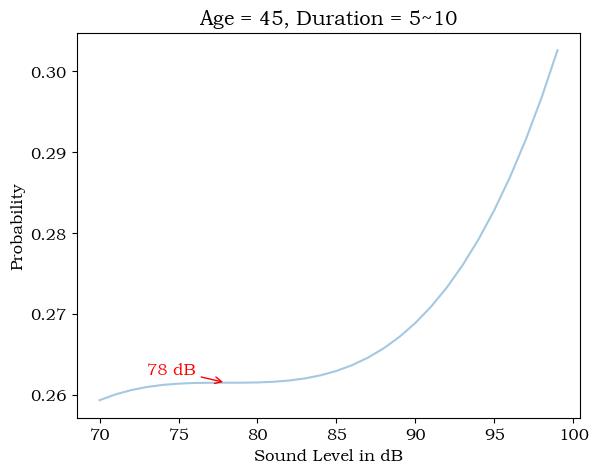

2024-03-25 23:49:00.435 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-25 23:49:00.436 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-25 23:49:00.436 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-25 23:49:00.436 | INFO     | __main__:udlr_res_plot:40 - f prime: [2.81714242e-03 2.47383949e-03 1.83212418e-03 1.28255879e-03
 8.29152993e-04 4.74600527e-04 2.20554035e-04 6.78912671e-05
 1.69756648e-05 6.79140492e-05 2.20813181e-04 4.76035792e-04
 8.34455448e-04 1.29770822e-03 1.86843755e-03 2.55052665e-03
 3.34930941e-03 4.27174634e-03 5.32654472e-03 6.52419161e-03
 7.87685347e-03 9.39807522e-03 1.11021854e-02 1.30032807e-02
 1.51136301e-02 1.74413072e-02 1.99868545e-02 2.27388267e-02
 2.56681958e-02 2.71723103e-02]
2024-03-25 23:49:00.438 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-3.43302930e-04 -4.92509121e-04 -5.95640351e-04 -5.01485592e-04
 

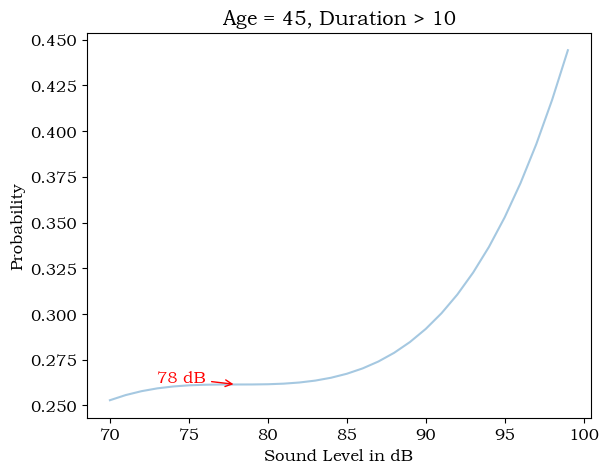

2024-03-25 23:49:00.554 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-25 23:49:00.555 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-25 23:49:00.555 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-25 23:49:00.556 | INFO     | __main__:udlr_res_plot:40 - f prime: [5.46473895e-04 4.78486973e-04 3.52275565e-04 2.45560793e-04
 1.58294573e-04 9.04441985e-05 4.19894333e-05 1.29194736e-05
 3.22983318e-06 1.29191918e-05 4.19862284e-05 9.04264482e-05
 1.58228996e-04 2.45373430e-04 3.51826422e-04 4.77538329e-04
 6.22439559e-04 7.86436661e-04 9.69408039e-04 1.17119918e-03
 1.39161727e-03 1.63042510e-03 1.88733410e-03 2.16199640e-03
 2.45399577e-03 2.76283738e-03 3.08793616e-03 3.42860390e-03
 3.78403489e-03 3.96533266e-03]
2024-03-25 23:49:00.557 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-6.79869224e-05 -9.70991650e-05 -1.16463090e-04 -9.69904961e-05
 

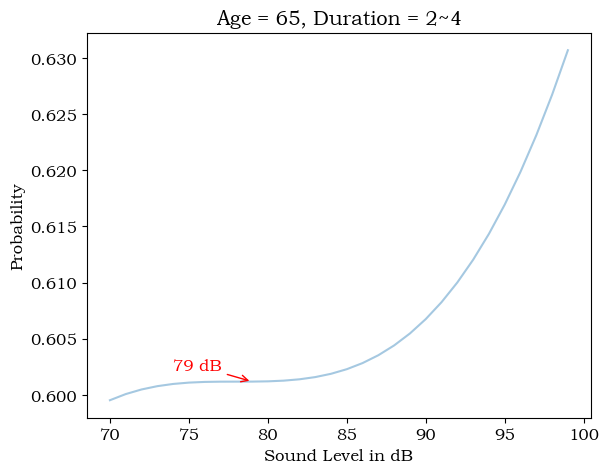

2024-03-25 23:49:00.657 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-25 23:49:00.657 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-25 23:49:00.658 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-25 23:49:00.659 | INFO     | __main__:udlr_res_plot:40 - f prime: [8.92201165e-04 7.81119444e-04 5.74956783e-04 4.00721456e-04
 2.58286802e-04 1.47566289e-04 6.85062269e-05 2.10779021e-05
 5.26938181e-06 2.10771522e-05 6.84976964e-05 1.47519043e-04
 2.58112255e-04 4.00222752e-04 5.73761307e-04 7.78594476e-04
 1.01453418e-03 1.28132605e-03 1.57863622e-03 1.90603599e-03
 2.26298405e-03 2.64880565e-03 3.06266832e-03 3.50355384e-03
 3.97022589e-03 4.46119354e-03 4.97467033e-03 5.50852953e-03
 6.06025608e-03 6.34024599e-03]
2024-03-25 23:49:00.660 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-1.11081722e-04 -1.58622191e-04 -1.90198994e-04 -1.58334990e-04
 

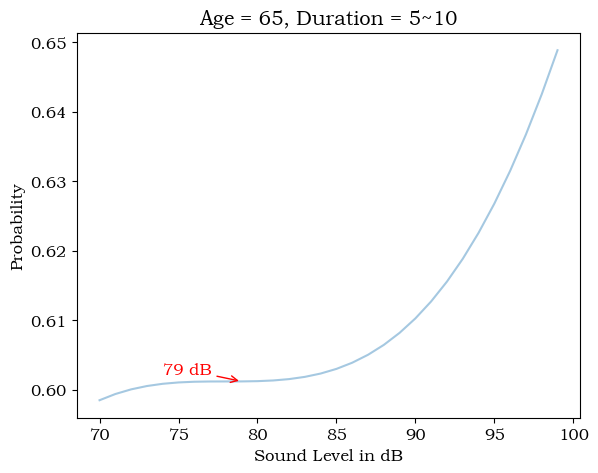

2024-03-25 23:49:00.756 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.29803684  0.07243739  1.32653869  2.16421049  8.65684751  3.        ]
2024-03-25 23:49:00.756 | INFO     | __main__:udlr_res_plot:28 - L_control: 78
2024-03-25 23:49:00.757 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 124.17853556998016
2024-03-25 23:49:00.758 | INFO     | __main__:udlr_res_plot:40 - f prime: [3.58806503e-03 3.13892982e-03 2.30678573e-03 1.60582407e-03
 1.03418434e-03 5.90547549e-04 2.74076157e-04 8.43161594e-05
 2.10775407e-05 8.43041605e-05 2.73939669e-04 5.89791618e-04
 1.03139164e-03 1.59784526e-03 2.28766097e-03 3.09854441e-03
 4.02714071e-03 5.06870669e-03 6.21669519e-03 7.46223796e-03
 8.79352221e-03 1.01950715e-02 1.16469649e-02 1.31240626e-02
 1.45953480e-02 1.60235448e-02 1.73652184e-02 1.85715963e-02
 1.95903405e-02 2.00461110e-02]
2024-03-25 23:49:00.758 | INFO     | __main__:udlr_res_plot:41 - f prime double: [-4.49135209e-04 -6.40639650e-04 -7.66552872e-04 -6.36300694e-04
 

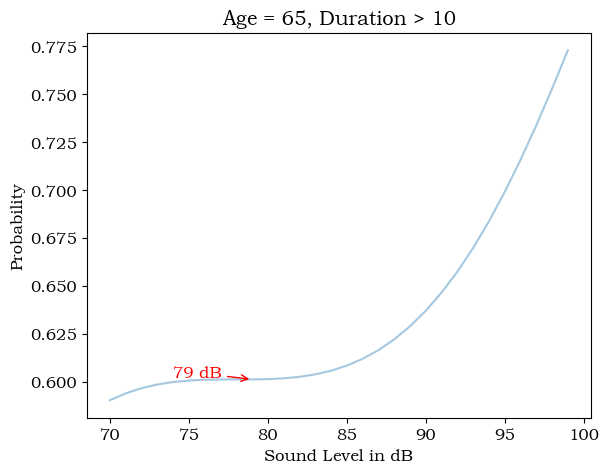

In [14]:
China_udlr_model = pickle.load(open(models_path / f"Chinese_experiment_group_udlr-_classifier_model.pkl", "rb"))

best_params_estimated = China_udlr_model[0]
best_L_control = China_udlr_model[1]
max_LAeq = China_udlr_model[2]

point_type = "2nd_critical"

udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)


udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)


udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)

2024-03-25 17:13:53.176 | INFO     | __main__:udlr_res_plot:26 - Params: [-7.12307019  0.10908154  4.51408744  4.75434295  4.47696263  1.18102112]
2024-03-25 17:13:53.177 | INFO     | __main__:udlr_res_plot:27 - L_control: 70
2024-03-25 17:13:53.177 | INFO     | __main__:udlr_res_plot:28 - max LAeq: 124.17853556998016


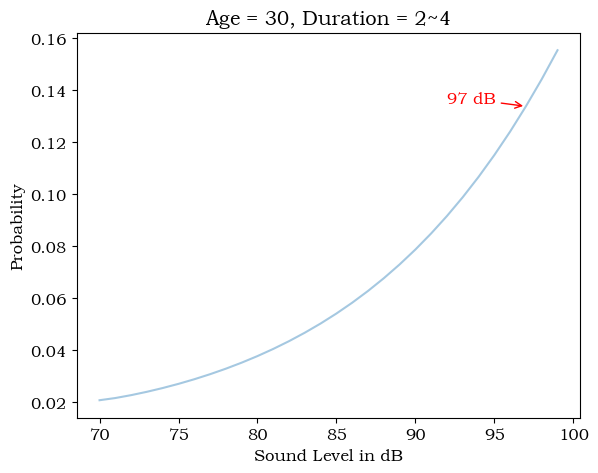

2024-03-25 17:13:53.286 | INFO     | __main__:udlr_res_plot:26 - Params: [-7.12307019  0.10908154  4.51408744  4.75434295  4.47696263  1.18102112]
2024-03-25 17:13:53.286 | INFO     | __main__:udlr_res_plot:27 - L_control: 70
2024-03-25 17:13:53.286 | INFO     | __main__:udlr_res_plot:28 - max LAeq: 124.17853556998016


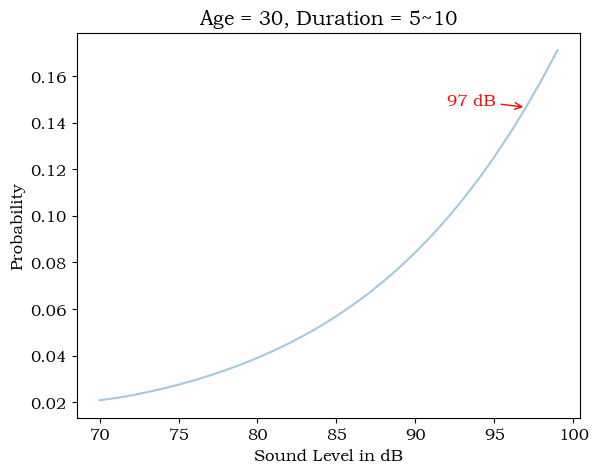

2024-03-25 17:13:53.376 | INFO     | __main__:udlr_res_plot:26 - Params: [-7.12307019  0.10908154  4.51408744  4.75434295  4.47696263  1.18102112]
2024-03-25 17:13:53.376 | INFO     | __main__:udlr_res_plot:27 - L_control: 70
2024-03-25 17:13:53.376 | INFO     | __main__:udlr_res_plot:28 - max LAeq: 124.17853556998016


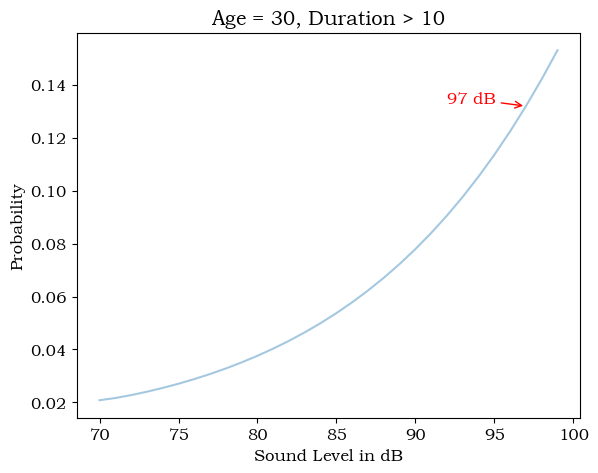

2024-03-25 17:13:53.470 | INFO     | __main__:udlr_res_plot:26 - Params: [-7.12307019  0.10908154  4.51408744  4.75434295  4.47696263  1.18102112]
2024-03-25 17:13:53.471 | INFO     | __main__:udlr_res_plot:27 - L_control: 70
2024-03-25 17:13:53.471 | INFO     | __main__:udlr_res_plot:28 - max LAeq: 124.17853556998016


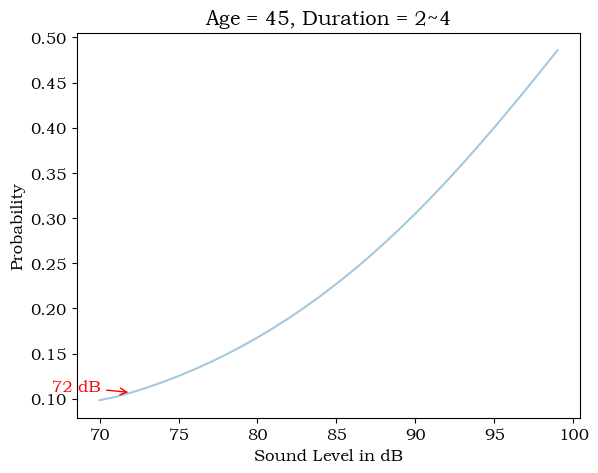

2024-03-25 17:13:53.561 | INFO     | __main__:udlr_res_plot:26 - Params: [-7.12307019  0.10908154  4.51408744  4.75434295  4.47696263  1.18102112]
2024-03-25 17:13:53.561 | INFO     | __main__:udlr_res_plot:27 - L_control: 70
2024-03-25 17:13:53.561 | INFO     | __main__:udlr_res_plot:28 - max LAeq: 124.17853556998016


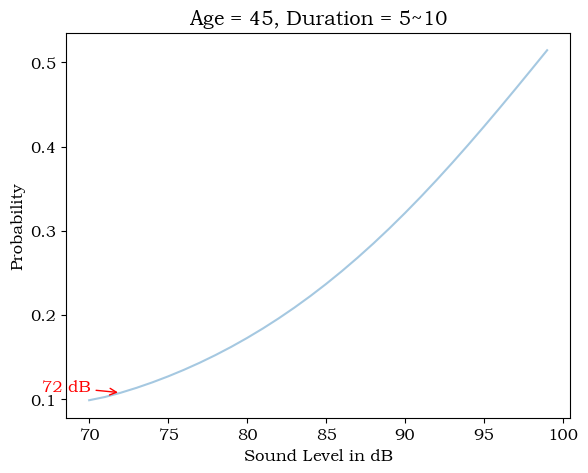

2024-03-25 17:13:53.647 | INFO     | __main__:udlr_res_plot:26 - Params: [-7.12307019  0.10908154  4.51408744  4.75434295  4.47696263  1.18102112]
2024-03-25 17:13:53.647 | INFO     | __main__:udlr_res_plot:27 - L_control: 70
2024-03-25 17:13:53.647 | INFO     | __main__:udlr_res_plot:28 - max LAeq: 124.17853556998016


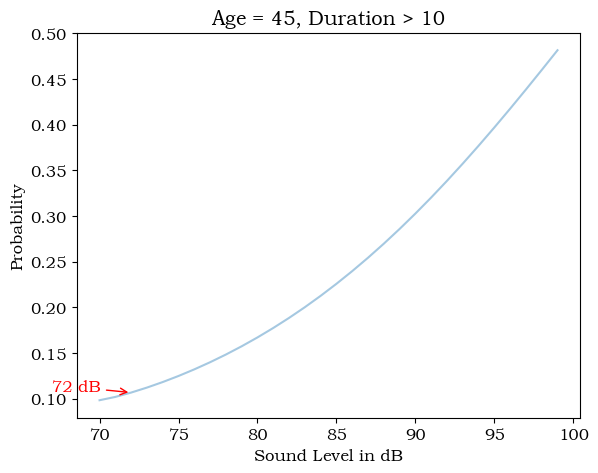

2024-03-25 17:13:53.740 | INFO     | __main__:udlr_res_plot:26 - Params: [-7.12307019  0.10908154  4.51408744  4.75434295  4.47696263  1.18102112]
2024-03-25 17:13:53.740 | INFO     | __main__:udlr_res_plot:27 - L_control: 70
2024-03-25 17:13:53.740 | INFO     | __main__:udlr_res_plot:28 - max LAeq: 124.17853556998016


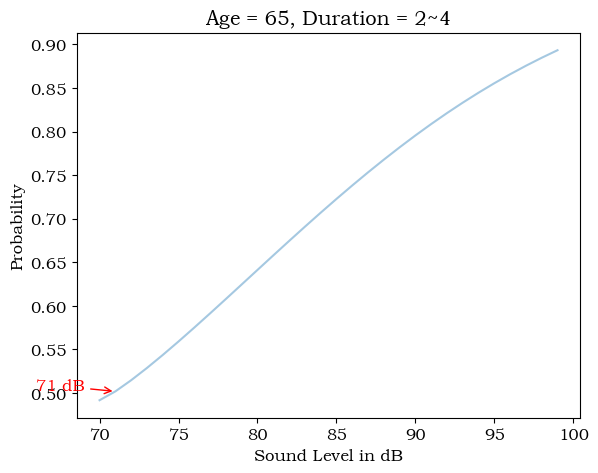

2024-03-25 17:13:53.876 | INFO     | __main__:udlr_res_plot:26 - Params: [-7.12307019  0.10908154  4.51408744  4.75434295  4.47696263  1.18102112]
2024-03-25 17:13:53.876 | INFO     | __main__:udlr_res_plot:27 - L_control: 70
2024-03-25 17:13:53.880 | INFO     | __main__:udlr_res_plot:28 - max LAeq: 124.17853556998016


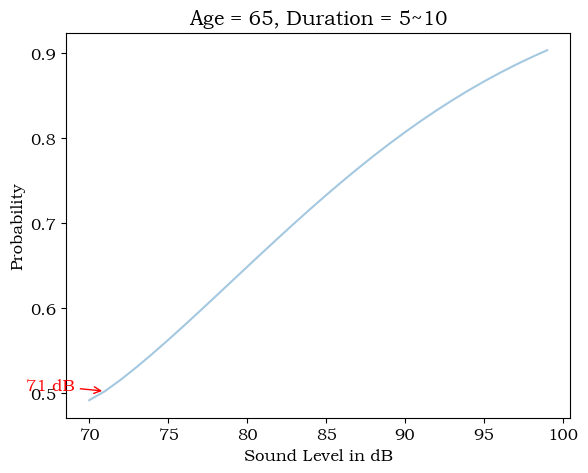

2024-03-25 17:13:53.964 | INFO     | __main__:udlr_res_plot:26 - Params: [-7.12307019  0.10908154  4.51408744  4.75434295  4.47696263  1.18102112]
2024-03-25 17:13:53.965 | INFO     | __main__:udlr_res_plot:27 - L_control: 70
2024-03-25 17:13:53.965 | INFO     | __main__:udlr_res_plot:28 - max LAeq: 124.17853556998016


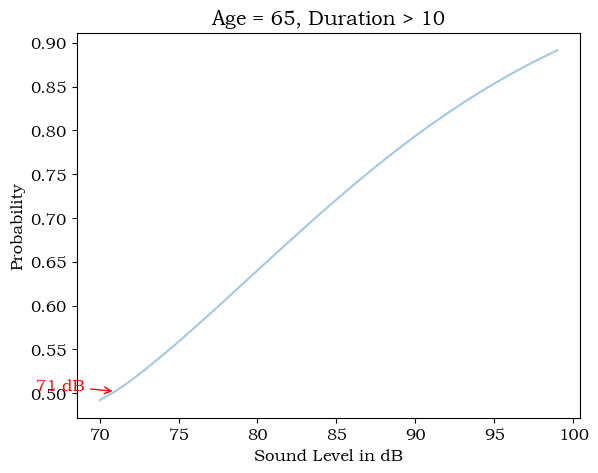

In [227]:
China_M_udlr_model = pickle.load(open(models_path / f"Chinese_experiment_group_M_udlr-_classifier_model.pkl", "rb"))

best_params_estimated = China_udlr_model[0]
best_L_control = China_udlr_model[1]
max_LAeq = China_udlr_model[2]

udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]))
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]))
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]))


udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]))
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]))
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]))


udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]))
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]))
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]))

### LR分类模型加载

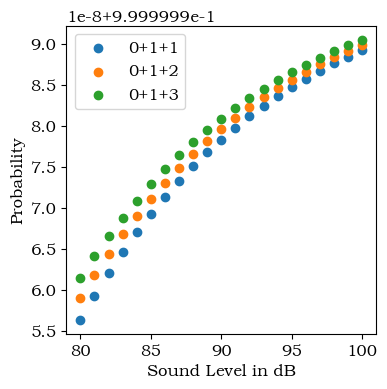

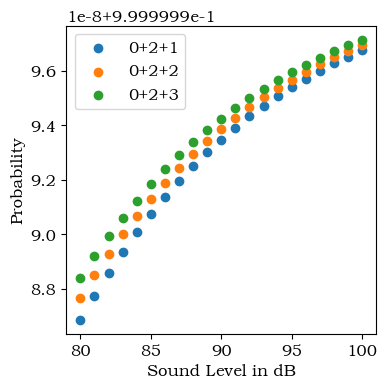

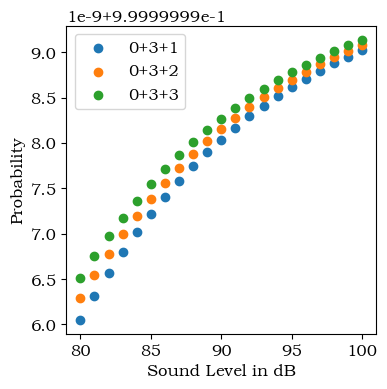

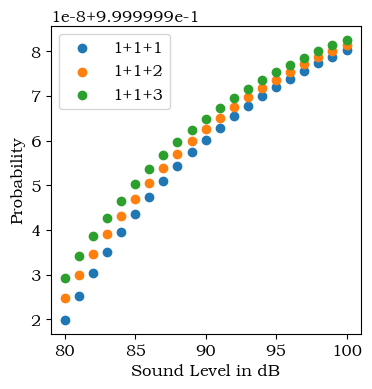

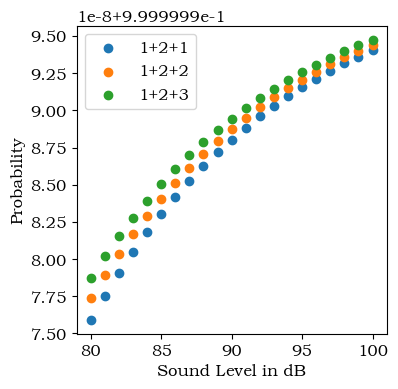

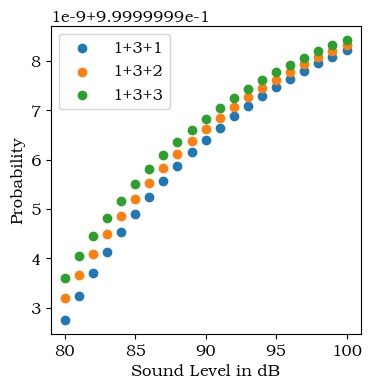

In [127]:
# Step 1
## 加载China的预测模型
China_predict_model_lr = pickle.load(open(models_path / f"Chinese_experiment_group_lr-{key_feature}_classifier_model.pkl", "rb"))

coefs = China_predict_model_lr.coef_
intercept = China_predict_model_lr.intercept_


# LAeq = np.arange(80, 101)
# X = np.stack([LAeq, [0]*len(LAeq), [1]*len(LAeq), [1]*len(LAeq)], axis=1)
# prob = 1 / (1 + np.exp(np.sum(X*coefs, axis=1)+intercept))

## 计算不同分组中，随LAeq变化NIHL确诊概率的变化情况
for sex in (0, 1):
    for age_box in (1,2,3):
        fig, ax = plt.subplots(1, figsize=(4,4))
        for duration_box in (1,2,3):
            LAeq = np.arange(80, 101)
            X = np.stack([LAeq, [sex]*len(LAeq), [age_box]*len(LAeq), [duration_box]*len(LAeq)], axis=1)
            prob = 1 / (1 + np.exp(-1*np.sum(X*coefs, axis=1)+intercept))
            ax.scatter(LAeq, prob, label=f"{sex}+{age_box}+{duration_box}")
        ax.set_ylabel("Probability")
        ax.set_xlabel("Sound Level in dB")
        plt.legend(loc="best")
        plt.show()

### 模型预测概率获取

d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


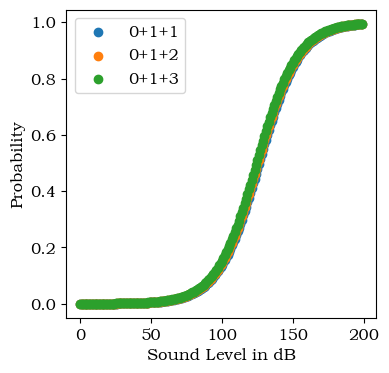

d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


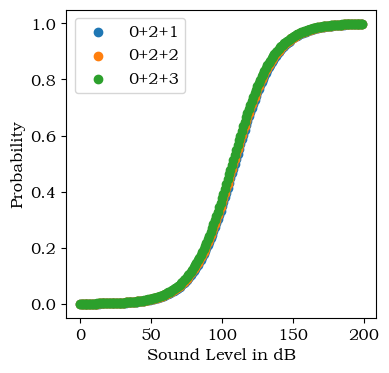

d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


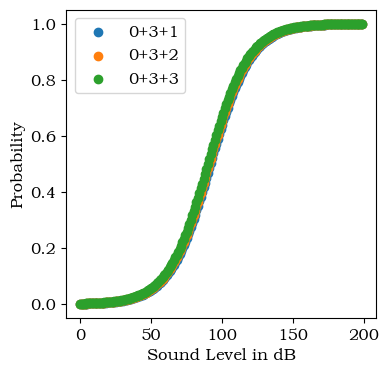

d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


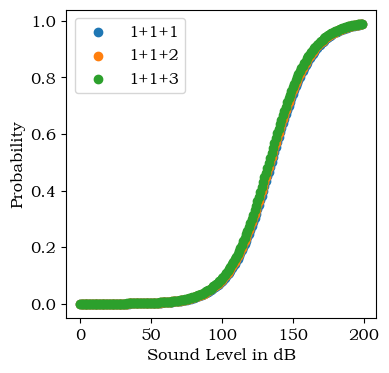

d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


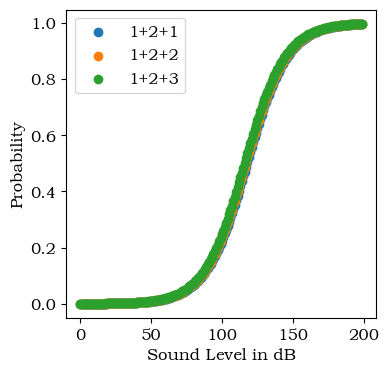

d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


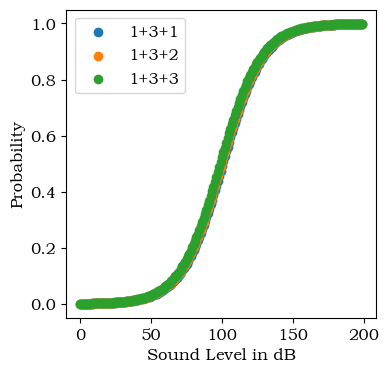

In [130]:
# Step 1
## 加载China的预测模型
China_predict_model = pickle.load(open(models_path / f"Chinese_experiment_group_lr-{key_feature}_classifier_model.pkl", "rb"))

## 获取不同分组中，随LAeq变化NIHL确诊概率的变化情况
for sex in (0, 1):
    for age_box in (1,2,3):
        fig, ax = plt.subplots(1, figsize=(4,4))
        for duration_box in (1,2,3):
            LAeq = np.arange(0, 200)
            X = np.stack([LAeq, [sex]*len(LAeq), [age_box]*len(LAeq), [duration_box]*len(LAeq)], axis=1)
            prob = China_predict_model.predict_proba(X)[:,1]
            ax.scatter(LAeq, prob, label=f"{sex}+{age_box}+{duration_box}")
        ax.set_ylabel("Probability")
        ax.set_xlabel("Sound Level in dB")
        plt.legend(loc="best")
        plt.show()

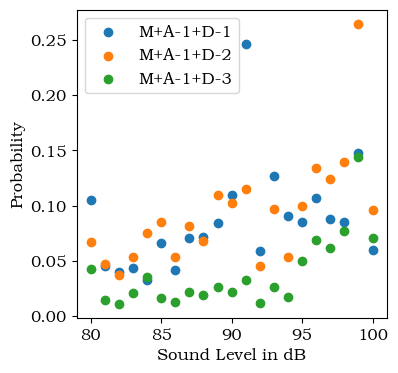

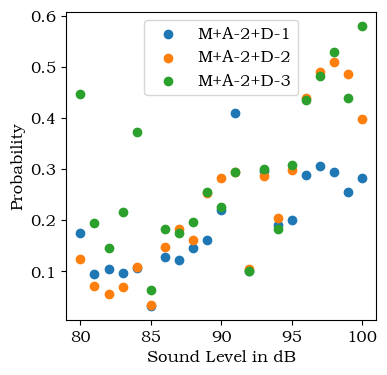

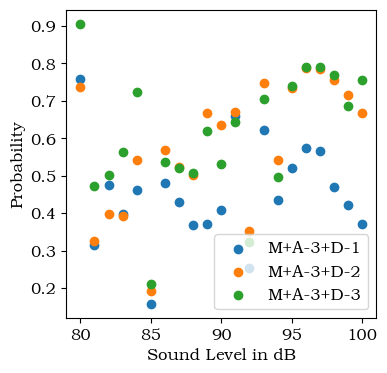

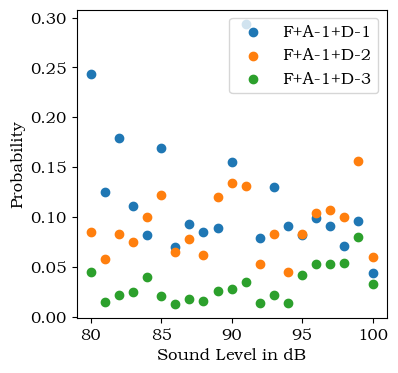

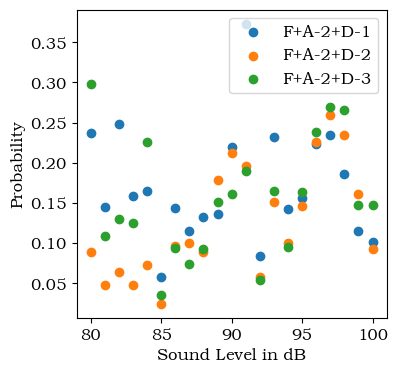

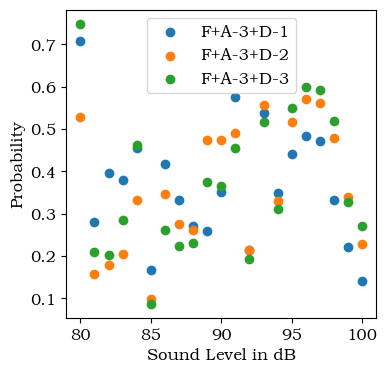

In [125]:
# Step 1
## 加载China的预测模型
China_predict_model = pickle.load(open(models_path / f"Chinese_experiment_group_catboost-{key_feature}_classifier_model.pkl", "rb"))

## 获取不同分组中，随LAeq变化NIHL确诊概率的变化情况
for sex in ("M", "F"):
    for age_box in ("A-1","A-2","A-3"):
        fig, ax = plt.subplots(1, figsize=(4,4))
        for duration_box in ("D-1","D-2","D-3"):
            LAeq = np.arange(80, 101)
            X = np.stack([LAeq, [sex]*len(LAeq), [age_box]*len(LAeq), [duration_box]*len(LAeq)], axis=1)
            prob = China_predict_model.predict_proba(X)[:,1]
            ax.scatter(LAeq, prob, label=f"{sex}+{age_box}+{duration_box}")
        ax.set_ylabel("Probability")
        ax.set_xlabel("Sound Level in dB")
        plt.legend(loc="best")
        plt.show()

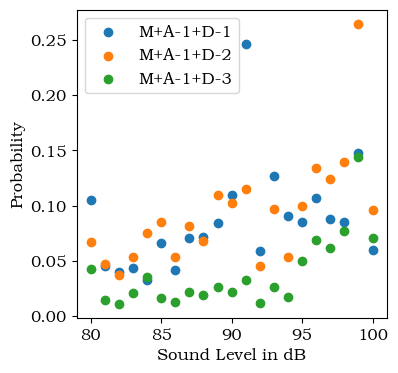

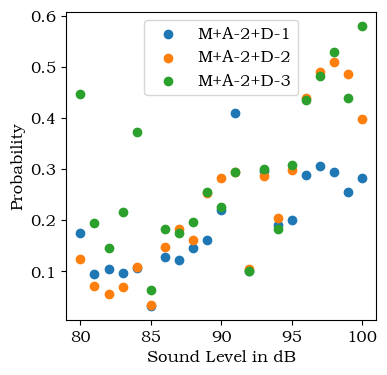

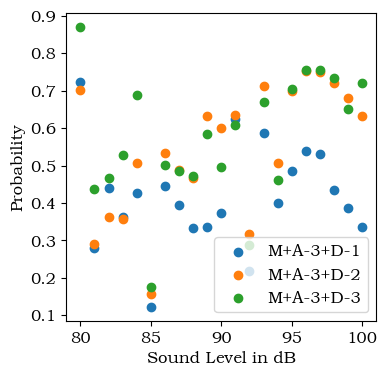

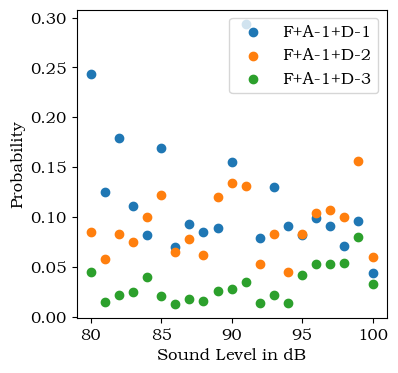

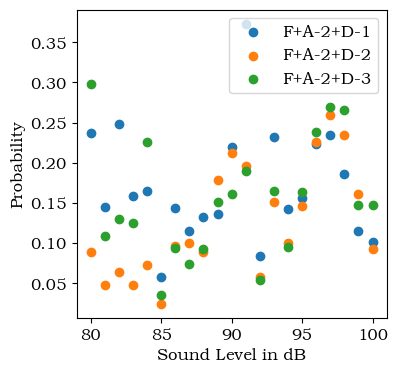

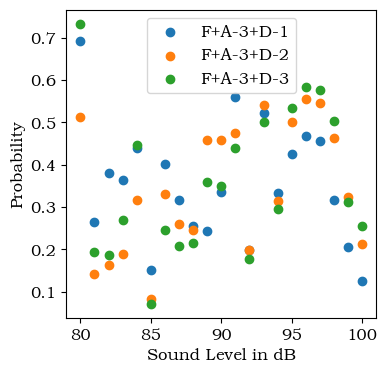

In [104]:
## 获取不同分组中，随LAeq变化NIHL确诊超额概率（减去对照组概率）的变化情况
for sex in ("M", "F"):
    for age_box in ("A-1","A-2","A-3"):
        fig, ax = plt.subplots(1, figsize=(4,4))
        for duration_box, color in zip(("D-1","D-2","D-3"), ('#1f77b4', '#ff7f0e', '#2ca02c')):
            LAeq = np.arange(80, 101)
            X = np.stack([LAeq, [sex]*len(LAeq), [age_box]*len(LAeq), [duration_box]*len(LAeq)], axis=1)
            prob = China_predict_model.predict_proba(X)[:,1]
            control_prob = float(China_control_group_base_prob.loc[sex, age_box])
            # logger.info(f"predict prob: {prob}")
            # logger.info(f"risk prob: {prob - control_prob}")
            # ax.scatter(LAeq, prob, marker="*", color=color, label=f"{sex}+{age_box}+{duration_box}")
            ax.scatter(LAeq, prob-control_prob, marker="o", color=color, label=f"{sex}+{age_box}+{duration_box}")
        ax.set_ylabel("Probability")
        ax.set_xlabel("Sound Level in dB")
        plt.legend(loc="best")
        plt.show()

### 模型预测概率拟合

2024-03-19 16:28:11.136 | INFO     | __main__:<module>:13 - curve fit parameters: [161.87493153  30.21561913]
2024-03-19 16:28:11.141 | INFO     | __main__:<module>:13 - curve fit parameters: [125.3395159   15.04326095]
2024-03-19 16:28:11.146 | INFO     | __main__:<module>:13 - curve fit parameters: [115.87473513   7.20275108]


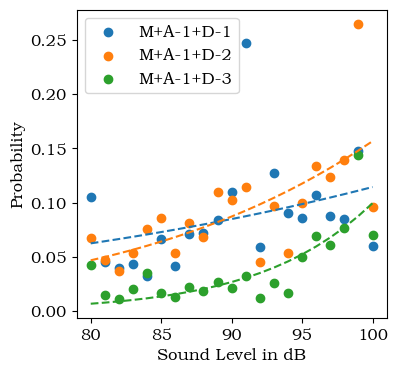

2024-03-19 16:28:11.246 | INFO     | __main__:<module>:13 - curve fit parameters: [111.0381058  14.0452656]
2024-03-19 16:28:11.249 | INFO     | __main__:<module>:13 - curve fit parameters: [99.93392351  7.50535313]
2024-03-19 16:28:11.252 | INFO     | __main__:<module>:13 - curve fit parameters: [102.04365626  12.61117042]


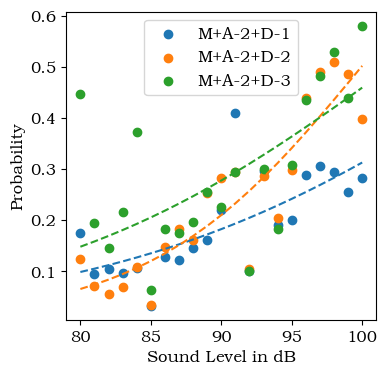

2024-03-19 16:28:11.348 | INFO     | __main__:<module>:13 - curve fit parameters: [142.95510041 160.55729185]
2024-03-19 16:28:11.350 | INFO     | __main__:<module>:13 - curve fit parameters: [87.17037989 14.23768894]
2024-03-19 16:28:11.353 | INFO     | __main__:<module>:13 - curve fit parameters: [82.03757706 26.60939318]


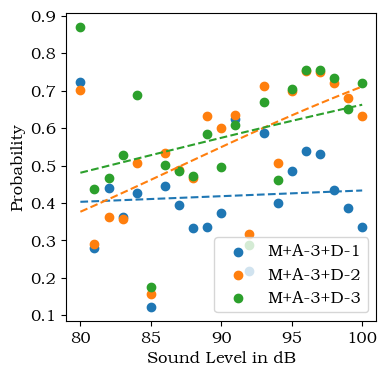

2024-03-19 16:28:11.505 | INFO     | __main__:<module>:13 - curve fit parameters: [1.59638896e+09 7.93389421e+08]
2024-03-19 16:28:11.508 | INFO     | __main__:<module>:13 - curve fit parameters: [286.34312235  85.00701613]
2024-03-19 16:28:11.510 | INFO     | __main__:<module>:13 - curve fit parameters: [147.47069084  16.41133205]


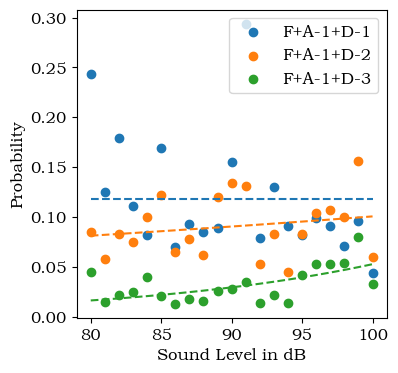

2024-03-19 16:28:11.619 | INFO     | __main__:<module>:13 - curve fit parameters: [40446406.42793439 25713024.13902038]
2024-03-19 16:28:11.622 | INFO     | __main__:<module>:13 - curve fit parameters: [122.60093321  16.47235292]
2024-03-19 16:28:11.624 | INFO     | __main__:<module>:13 - curve fit parameters: [168.88167326  46.09559425]


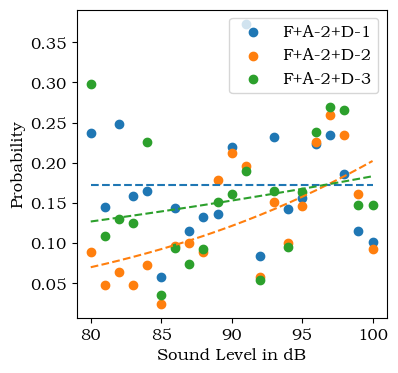

2024-03-19 16:28:11.715 | INFO     | __main__:<module>:13 - curve fit parameters: [2.82692819e+08 4.73552290e+08]
2024-03-19 16:28:11.719 | INFO     | __main__:<module>:13 - curve fit parameters: [104.44960448  22.56093792]
2024-03-19 16:28:11.721 | INFO     | __main__:<module>:13 - curve fit parameters: [109.55622995  32.38735838]


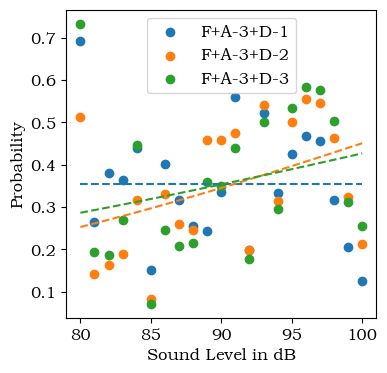

In [106]:
initial_guess = [90, 10]
## 获取不同分组中，使用S曲线拟合随LAeq变化NIHL确诊超额概率（减去对照组概率）的变化情况
for sex in ("M", "F"):
    for age_box in ("A-1","A-2","A-3"):
        fig, ax = plt.subplots(1, figsize=(4,4))
        for duration_box, color in zip(("D-1","D-2","D-3"), ('#1f77b4', '#ff7f0e', '#2ca02c')):
            LAeq = np.arange(80, 101)
            X = np.stack([LAeq, [sex]*len(LAeq), [age_box]*len(LAeq), [duration_box]*len(LAeq)], axis=1)
            prob = China_predict_model.predict_proba(X)[:,1]
            control_prob = float(China_control_group_base_prob.loc[sex, age_box])
            excess_risk = prob - control_prob
            popt, pcov = curve_fit(logistic_pdf, LAeq, excess_risk, p0=initial_guess)
            logger.info(f"curve fit parameters: {popt}")
            ax.scatter(LAeq, excess_risk, marker="o", color=color, label=f"{sex}+{age_box}+{duration_box}")
            ax.plot(LAeq, logistic_pdf(LAeq, *popt), color=color, linestyle="--")
        ax.set_ylabel("Probability")
        ax.set_xlabel("Sound Level in dB")
        plt.legend(loc="best")
        plt.show()

## NOISH实验组数据

* NOISH数据中LAeq的范围为80~100 dB，所以此处获取不同LAeq下的概率分布时，首先使用80~100 dB范围的概率进行拟合，拟合后的函数再扩展到更大的LAeq范围；
* A-2+D-1组展现出的预测概率分布情况明显异于其他情况

### NOISH原始数据预览

In [38]:
# Step 0
## 加载实验组原始数据
NOISH_experiment_group_origin_df = pd.read_csv(cache_path/f"NOISH_extract_experiment_classifier_df.csv", header=0)

## 对年龄、工龄进行分组
NOISH_experiment_group_origin_df["age_box"] = NOISH_experiment_group_origin_df["age"].apply(
            lambda x: mark_group_name(x, qcut_set=age_cut, prefix="A-"))
NOISH_experiment_group_origin_df["duration_box"] = NOISH_experiment_group_origin_df["duration"].apply(
            lambda x: mark_group_name(x, qcut_set=duration_cut, prefix="D-"))


In [142]:
NOISH_experiment_group_origin_df.HL1234_Y.value_counts()

0    519
1    233
Name: HL1234_Y, dtype: int64

In [40]:
NOISH_experiment_group_origin_df.groupby(["sex","age_box","duration_box"])["HL1234_Y"].count()

sex  age_box  duration_box
M    A-1      D-1             148
              D-2              47
              D-3               7
     A-2      D-1              46
              D-2              81
              D-3             105
     A-3      D-1              25
              D-2              35
              D-3             258
Name: HL1234_Y, dtype: int64

In [41]:
NOISH_experiment_group_origin_df.groupby(["sex", "age_box","duration_box"])["HL1234_Y"].sum()

sex  age_box  duration_box
M    A-1      D-1               8
              D-2               4
              D-3               2
     A-2      D-1              10
              D-2              17
              D-3              38
     A-3      D-1               9
              D-2              14
              D-3             131
Name: HL1234_Y, dtype: int64

### 自定义LR分类模型加载

#### 论文复现结果

2024-03-25 23:58:23.377 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.18049946  0.07176393  1.32653869  2.13749184  8.65684751  3.6808356 ]
2024-03-25 23:58:23.378 | INFO     | __main__:udlr_res_plot:28 - L_control: 79
2024-03-25 23:58:23.379 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102.0
C:\Users\Liuhe\AppData\Local\Temp\ipykernel_66048\674183680.py:10: RuntimeWarning: invalid value encountered in power
  beta21 * np.power(x[:, 1], phi) + \
2024-03-25 23:58:23.380 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 8.50097393e-06 3.71576190e-05
 1.00601956e-04 2.10490700e-04 3.77547907e-04 6.12359833e-04
 9.26061274e-04 1.33108696e-03 1.84206291e-03 2.47689511e-03
 3.25811477e-03 4.21454693e-03 5.38337378e-03 6.81265392e-03
 8.56430968e-03 1.07174626e-02 1.33716987e-02 1.66492346e-02
 2.06938070e-02 2.29270556e-02]
2024

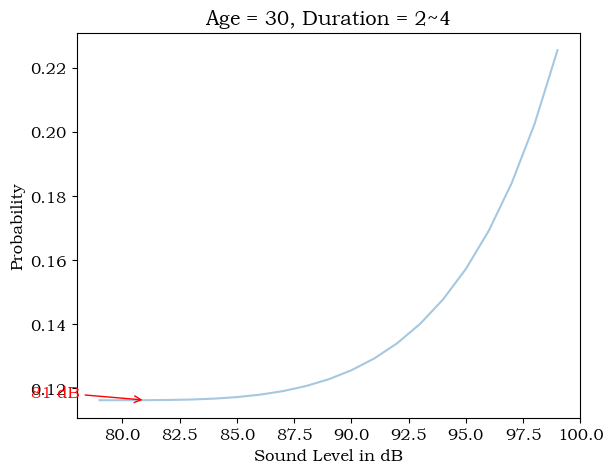

2024-03-25 23:58:23.497 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.18049946  0.07176393  1.32653869  2.13749184  8.65684751  3.6808356 ]
2024-03-25 23:58:23.498 | INFO     | __main__:udlr_res_plot:28 - L_control: 79
2024-03-25 23:58:23.498 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102.0
C:\Users\Liuhe\AppData\Local\Temp\ipykernel_66048\674183680.py:11: RuntimeWarning: invalid value encountered in power
  beta22 * np.power(x[:, 2], phi) + \
2024-03-25 23:58:23.499 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 1.36984073e-05 5.98837045e-05
 1.62189897e-04 3.39612121e-04 6.10002684e-04 9.91677336e-04
 1.50499438e-03 2.17422389e-03 3.02988237e-03 4.11170053e-03
 5.47241236e-03 7.18255934e-03 9.33643667e-03 1.20590440e-02
 1.55131911e-02 1.99042649e-02 2.54767503e-02 3.24903094e-02
 4.11535521e-02 4.59175340e-02]
2024

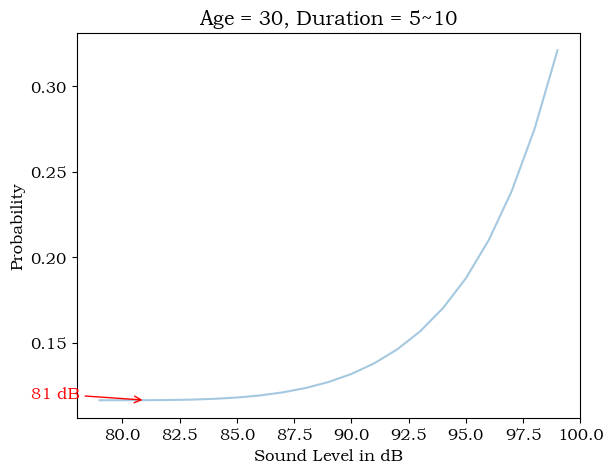

2024-03-25 23:58:23.602 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.18049946  0.07176393  1.32653869  2.13749184  8.65684751  3.6808356 ]
2024-03-25 23:58:23.603 | INFO     | __main__:udlr_res_plot:28 - L_control: 79
2024-03-25 23:58:23.603 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102.0
C:\Users\Liuhe\AppData\Local\Temp\ipykernel_66048\674183680.py:12: RuntimeWarning: invalid value encountered in power
  beta23 * np.power(x[:, 3], phi)
2024-03-25 23:58:23.604 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 5.54958864e-05 2.42871616e-04
 6.59705246e-04 1.38988873e-03 2.52465759e-03 4.18045977e-03
 6.52292678e-03 9.80081112e-03 1.43934783e-02 2.08722611e-02
 3.00601431e-02 4.30221232e-02 6.07862479e-02 8.33750364e-02
 1.07760293e-01 1.25830335e-01 1.26663970e-01 1.05755129e-01
 7.18150717e-02 5.35374973e-02]
2024-03-

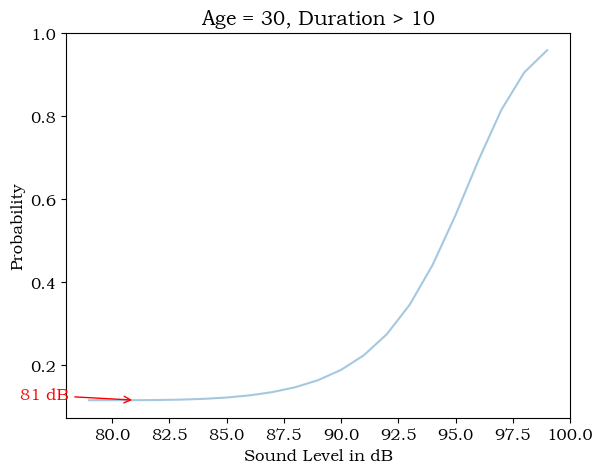

2024-03-25 23:58:23.714 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.18049946  0.07176393  1.32653869  2.13749184  8.65684751  3.6808356 ]
2024-03-25 23:58:23.714 | INFO     | __main__:udlr_res_plot:28 - L_control: 79
2024-03-25 23:58:23.715 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102.0
2024-03-25 23:58:23.716 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 1.66213108e-05 7.26446018e-05
 1.96631643e-04 4.11195994e-04 7.36824052e-04 1.19315191e-03
 1.79989792e-03 2.57774720e-03 3.54926551e-03 4.73984482e-03
 6.17862711e-03 7.89928353e-03 9.94042222e-03 1.23452371e-02
 1.51597677e-02 1.84287995e-02 2.21880124e-02 2.64505926e-02
 3.11864731e-02 3.36654994e-02]
2024-03-25 23:58:23.717 | INFO     | __main__:udlr_res_plot:41 - f prime double: [           nan            nan            nan            nan
            nan   

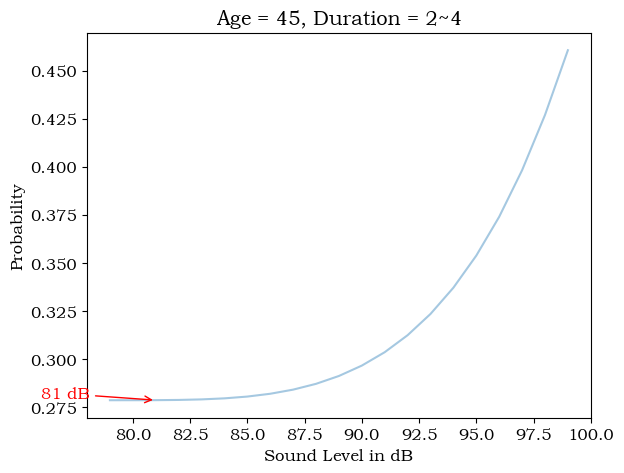

2024-03-25 23:58:23.834 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.18049946  0.07176393  1.32653869  2.13749184  8.65684751  3.6808356 ]
2024-03-25 23:58:23.834 | INFO     | __main__:udlr_res_plot:28 - L_control: 79
2024-03-25 23:58:23.835 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102.0
2024-03-25 23:58:23.835 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 2.67830192e-05 1.17066290e-04
 3.16936384e-04 6.63069160e-04 1.18911086e-03 1.92807708e-03
 2.91431216e-03 4.18546127e-03 5.78451317e-03 7.76177502e-03
 1.01764102e-02 1.30968098e-02 1.65984838e-02 2.07572563e-02
 2.56343251e-02 3.12484887e-02 3.75306057e-02 4.42586258e-02
 5.09824934e-02 5.42705122e-02]
2024-03-25 23:58:23.836 | INFO     | __main__:udlr_res_plot:41 - f prime double: [       nan        nan        nan        nan        nan        nan
        nan 

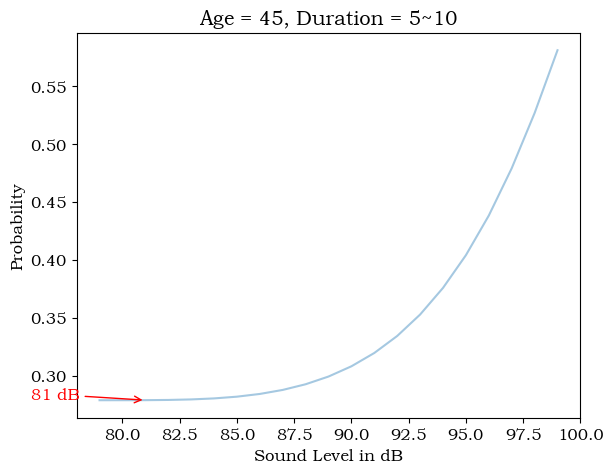

2024-03-25 23:58:24.029 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.18049946  0.07176393  1.32653869  2.13749184  8.65684751  3.6808356 ]
2024-03-25 23:58:24.029 | INFO     | __main__:udlr_res_plot:28 - L_control: 79
2024-03-25 23:58:24.030 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102.0
2024-03-25 23:58:24.031 | INFO     | __main__:udlr_res_plot:40 - f prime: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.00010849 0.0004745
 0.00128677 0.00270153 0.0048754  0.00798522 0.01224737 0.01793311
 0.02536648 0.0348741  0.04662699 0.06028977 0.07444381 0.08604333
 0.09073676 0.08498179 0.06911823 0.04816417 0.0286475  0.02000365]
2024-03-25 23:58:24.032 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan  0.00058914
  0.00111351  0.00179431  0.00264184  0.00368599  0.00497

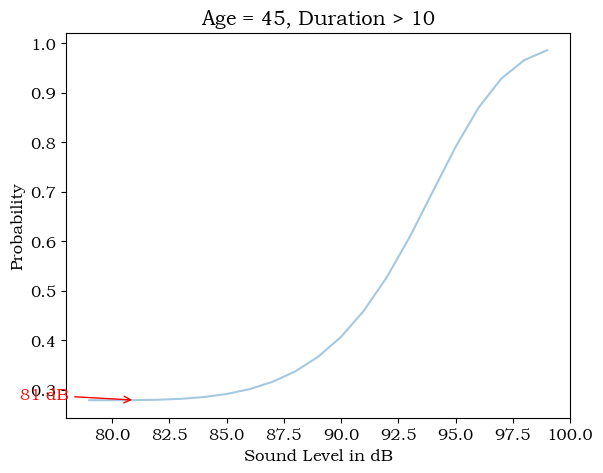

2024-03-25 23:58:24.157 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.18049946  0.07176393  1.32653869  2.13749184  8.65684751  3.6808356 ]
2024-03-25 23:58:24.159 | INFO     | __main__:udlr_res_plot:28 - L_control: 79
2024-03-25 23:58:24.159 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102.0
2024-03-25 23:58:24.160 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 1.95056913e-05 8.52340846e-05
 2.30587745e-04 4.81668684e-04 8.61345000e-04 1.39009557e-03
 2.08618149e-03 2.96545910e-03 4.04089121e-03 5.32172945e-03
 6.81229416e-03 8.51025033e-03 1.04042737e-02 1.24710409e-02
 1.46715904e-02 1.69473293e-02 1.92163340e-02 2.13711153e-02
 2.32795946e-02 2.41543087e-02]
2024-03-25 23:58:24.161 | INFO     | __main__:udlr_res_plot:41 - f prime double: [       nan        nan        nan        nan        nan        nan
        nan 

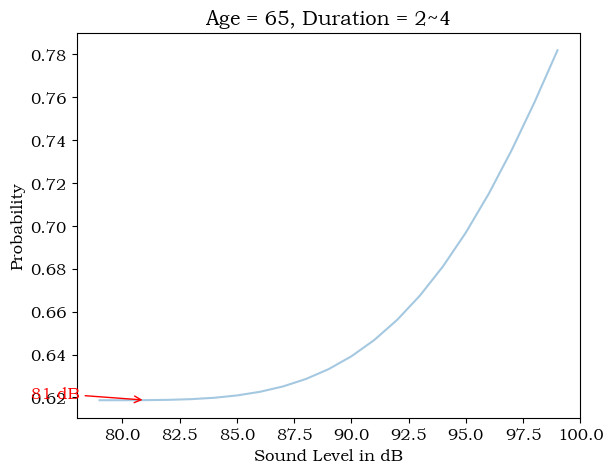

2024-03-25 23:58:24.268 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.18049946  0.07176393  1.32653869  2.13749184  8.65684751  3.6808356 ]
2024-03-25 23:58:24.269 | INFO     | __main__:udlr_res_plot:28 - L_control: 79
2024-03-25 23:58:24.269 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102.0
2024-03-25 23:58:24.270 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 3.14297319e-05 1.37332784e-04
 3.71491124e-04 7.75811674e-04 1.38672829e-03 2.23631157e-03
 3.35215063e-03 4.75644326e-03 6.46427717e-03 8.48091234e-03
 1.07977851e-02 1.33869627e-02 1.61939669e-02 1.91293939e-02
 2.20607355e-02 2.48073101e-02 2.71429733e-02 2.88123954e-02
 2.95654953e-02 2.96834171e-02]
2024-03-25 23:58:24.271 | INFO     | __main__:udlr_res_plot:41 - f prime double: [       nan        nan        nan        nan        nan        nan
        nan 

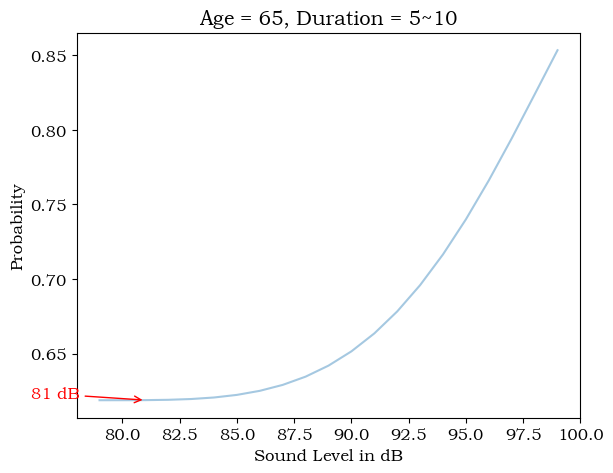

2024-03-25 23:58:24.370 | INFO     | __main__:udlr_res_plot:27 - Params: [-4.18049946  0.07176393  1.32653869  2.13749184  8.65684751  3.6808356 ]
2024-03-25 23:58:24.371 | INFO     | __main__:udlr_res_plot:28 - L_control: 79
2024-03-25 23:58:24.372 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102.0
2024-03-25 23:58:24.373 | INFO     | __main__:udlr_res_plot:40 - f prime: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.00012728 0.00055595
 0.00150251 0.0031316  0.00557657 0.00893391 0.01324498 0.01846185
 0.02439271 0.03062886 0.03647555 0.04094754 0.04292506 0.04153353
 0.03664176 0.02914694 0.02071924 0.0130772  0.00729389 0.00494448]
2024-03-25 23:58:24.373 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan  0.00068762
  0.00128782  0.00203703  0.00290115  0.00383421  0.0047

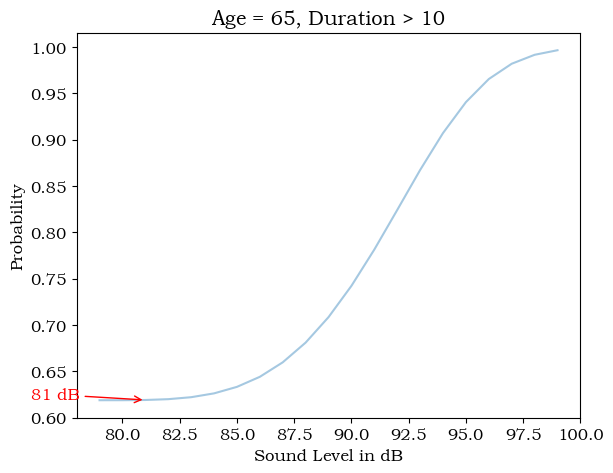

In [20]:
NOISH_udlr_model = pickle.load(open(models_path / f"NOISH_experiment_group_udlr-_classifier_model.pkl", "rb"))

best_params_estimated = NOISH_udlr_model[0]
best_L_control = NOISH_udlr_model[1]
max_LAeq = NOISH_udlr_model[2]

point_type = "2nd_critical"

udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)


udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)


udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)


#### 原文数值结果

2024-03-26 00:08:38.242 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:08:38.243 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:08:38.246 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
C:\Users\Liuhe\AppData\Local\Temp\ipykernel_66048\674183680.py:10: RuntimeWarning: invalid value encountered in power
  beta21 * np.power(x[:, 1], phi) + \
2024-03-26 00:08:38.251 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 9.49166508e-06 3.67903929e-05 9.08271532e-05 1.76871842e-04
 2.99495068e-04 4.63241462e-04 6.73107633e-04 9.35001944e-04
 1.25624756e-03 1.64616990e-03 2.11680953e-03 2.68380893e-03
 3.36753293e-03 4.19449479e-03 5.19917037e-03 6.42628182e-03
 7.93360456e-03 9.79526229e-03 1.21052615e-02 1.49805657e-02
 1.85621338e-02 2.30107865e-02 2.84922680e-02 3.51425507e-02
 4.30016993e-02 4.72298474e-02]
2024-03-26 00:08:38.253 | INFO    

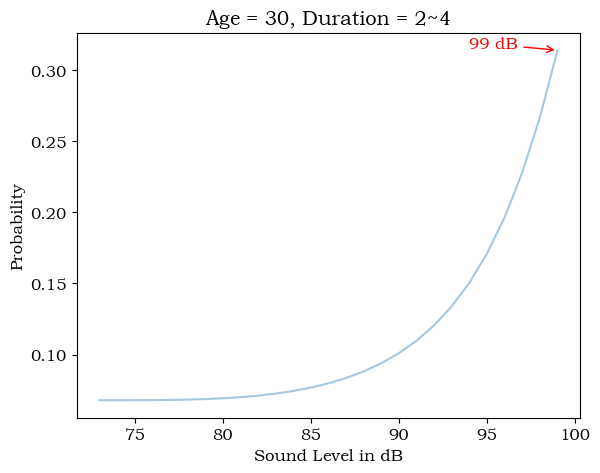

2024-03-26 00:08:38.366 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:08:38.367 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:08:38.367 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
C:\Users\Liuhe\AppData\Local\Temp\ipykernel_66048\674183680.py:11: RuntimeWarning: invalid value encountered in power
  beta22 * np.power(x[:, 2], phi) + \
2024-03-26 00:08:38.368 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 1.42065395e-05 5.50764570e-05 1.36036907e-04 2.65165957e-04
 4.49752247e-04 6.97477763e-04 1.01736577e-03 1.42077754e-03
 1.92258011e-03 2.54259162e-03 3.30742949e-03 4.25291790e-03
 5.42724615e-03 6.89508970e-03 8.74287267e-03 1.10851776e-02
 1.40718127e-02 1.78938750e-02 2.27846712e-02 2.90066839e-02
 3.68081705e-02 4.63238753e-02 5.73922512e-02 6.92897374e-02
 8.04761471e-02 8.56415019e-02]
2024-03-26 00:08:38.369 | INFO    

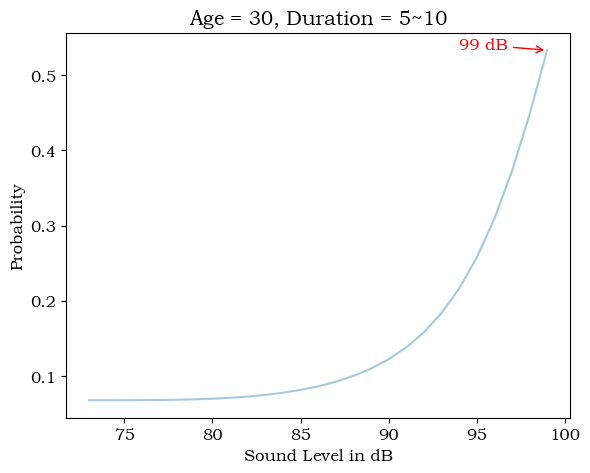

2024-03-26 00:08:38.482 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:08:38.484 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:08:38.484 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
C:\Users\Liuhe\AppData\Local\Temp\ipykernel_66048\674183680.py:12: RuntimeWarning: invalid value encountered in power
  beta23 * np.power(x[:, 3], phi)
2024-03-26 00:08:38.485 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 2.28692142e-05 8.86923821e-05 2.19261250e-04 4.28144790e-04
 7.28410949e-04 1.13507124e-03 1.66735369e-03 2.35135068e-03
 3.22338348e-03 4.33447079e-03 5.75639625e-03 7.58997691e-03
 9.97613386e-03 1.31099843e-02 1.72567673e-02 2.27645706e-02
 3.00598667e-02 3.95939809e-02 5.16807613e-02 6.61452245e-02
 8.17591775e-02 9.57031626e-02 1.03762696e-01 1.02033522e-01
 8.96010180e-02 8.08675566e-02]
2024-03-26 00:08:38.486 | INFO     | _

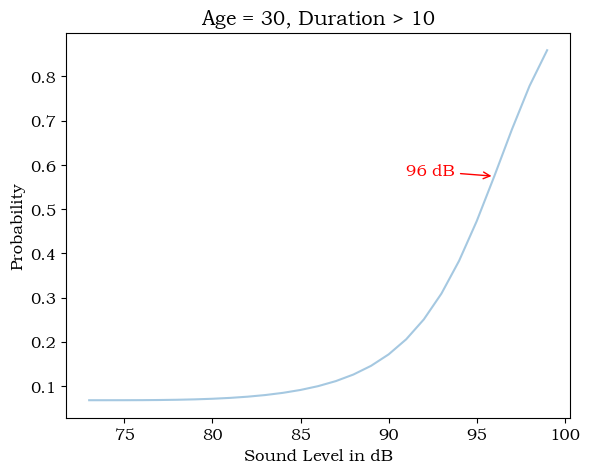

2024-03-26 00:08:38.629 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:08:38.629 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:08:38.630 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:08:38.631 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 2.37789947e-05 9.21581447e-05 2.27451213e-04 4.42667714e-04
 7.48803806e-04 1.15634878e-03 1.67623852e-03 2.32067521e-03
 3.10392621e-03 4.04314004e-03 5.15918374e-03 6.47747497e-03
 8.02874014e-03 9.84956178e-03 1.19824685e-02 1.44751496e-02
 1.73781254e-02 2.07398647e-02 2.45979554e-02 2.89646458e-02
 3.38052325e-02 3.90090489e-02 4.43561459e-02 4.94889412e-02
 5.39063525e-02 5.58649472e-02]
2024-03-26 00:08:38.631 | INFO     | __main__:udlr_res_plot:41 - f prime double: [       nan        nan        nan        nan        nan 0.00010184
 0.00017525 0.00026068 0.00035684 0.000463

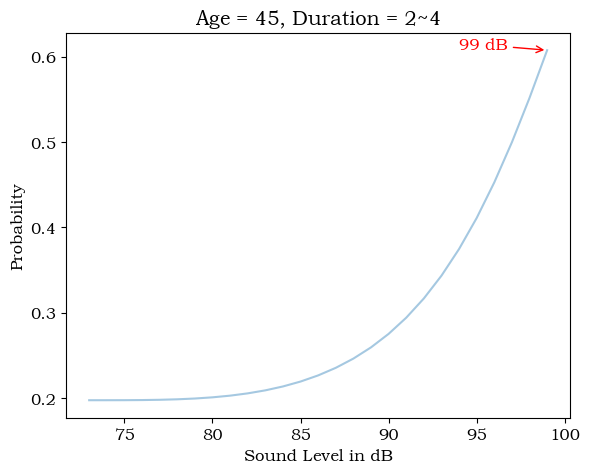

2024-03-26 00:08:38.719 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:08:38.720 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:08:38.720 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:08:38.721 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 3.55902464e-05 1.37953003e-04 3.40590158e-04 6.63305016e-04
 1.12332985e-03 1.73786547e-03 2.52585866e-03 3.50964024e-03
 4.71658069e-03 6.18078945e-03 7.94479087e-03 1.00609812e-02
 1.25924531e-02 1.56124069e-02 1.92007789e-02 2.34358561e-02
 2.83775844e-02 3.40384139e-02 4.03380151e-02 4.70423500e-02
 5.36986642e-02 5.95975231e-02 6.38141764e-02 6.53814022e-02
 6.35930732e-02 6.17992559e-02]
2024-03-26 00:08:38.722 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan  0.0001525
  0.00026268  0.00039137  0.00053728 

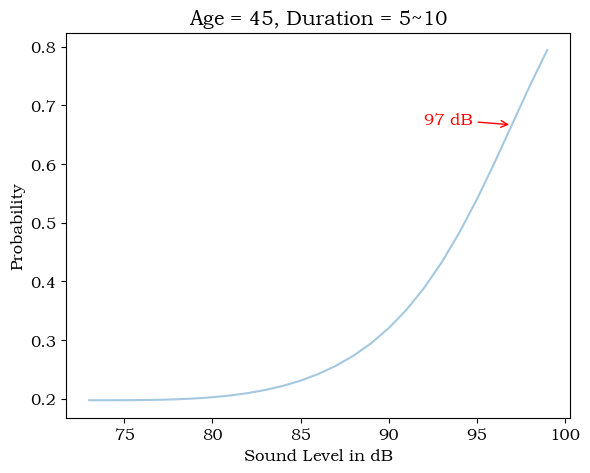

2024-03-26 00:08:38.822 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:08:38.822 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:08:38.823 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:08:38.824 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 5.72899596e-05 2.22120554e-04 5.48729596e-04 1.06997618e-03
 1.81589004e-03 2.81860337e-03 4.11624651e-03 5.75677663e-03
 7.80189479e-03 1.03308374e-02 1.34433329e-02 1.72601231e-02
 2.19178663e-02 2.75526807e-02 3.42631456e-02 4.20407214e-02
 5.06581890e-02 5.95252525e-02 6.75675421e-02 7.32550723e-02
 7.49350032e-02 7.14906541e-02 6.30287506e-02 5.10698004e-02
 3.79749083e-02 3.14614883e-02]
2024-03-26 00:08:38.825 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan  0.00024572
  0.00042393  0.00063358  0.00087431

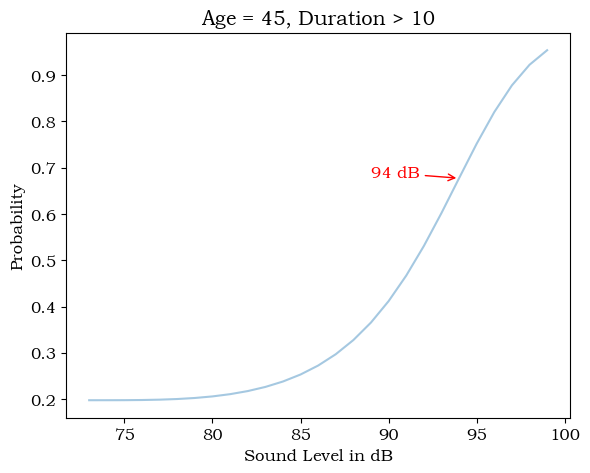

2024-03-26 00:08:38.926 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:08:38.926 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:08:38.926 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:08:38.927 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 3.70376385e-05 1.43496289e-04 3.53871672e-04 6.87602653e-04
 1.15988798e-03 1.78330760e-03 2.56838835e-03 3.52374323e-03
 4.65592173e-03 5.96898233e-03 7.46374444e-03 9.13665036e-03
 1.09781615e-02 1.29706350e-02 1.50856896e-02 1.72811978e-02
 1.94982473e-02 2.16587153e-02 2.36644506e-02 2.53993775e-02
 2.67359225e-02 2.75467585e-02 2.77217250e-02 2.71879061e-02
 2.59286986e-02 2.51197312e-02]
2024-03-26 00:08:38.928 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan  0.00015842
  0.00027205  0.00040301  0.00054785

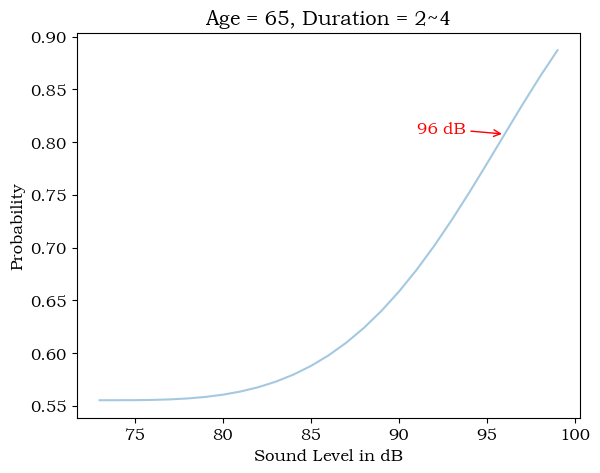

2024-03-26 00:08:39.027 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:08:39.028 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:08:39.028 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:08:39.029 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 5.54316288e-05 2.14755348e-04 5.29568158e-04 1.02886431e-03
 1.73514973e-03 2.66674682e-03 3.83843946e-03 5.26134571e-03
 6.94214619e-03 8.88158560e-03 1.10720766e-02 1.34942213e-02
 1.61121460e-02 1.88677820e-02 2.16746835e-02 2.44127126e-02
 2.69258874e-02 2.90266080e-02 3.05097402e-02 3.11787303e-02
 3.08823082e-02 2.95547058e-02 2.72469009e-02 2.41349983e-02
 2.04975037e-02 1.85873485e-02]
2024-03-26 00:08:39.030 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan  0.00023707
  0.00040705  0.00060279  0.00081894

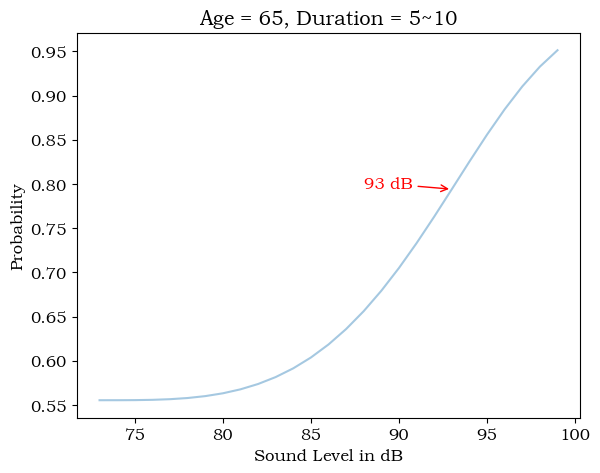

2024-03-26 00:08:39.131 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:08:39.131 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:08:39.131 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:08:39.132 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 8.92200841e-05 3.45643702e-04 8.52228432e-04 1.65534407e-03
 2.79046835e-03 4.28546951e-03 6.16088193e-03 8.42836456e-03
 1.10872244e-02 1.41185181e-02 1.74762218e-02 2.10753752e-02
 2.47782227e-02 2.83814960e-02 3.16110605e-02 3.41332530e-02
 3.55928096e-02 3.56815187e-02 3.42272436e-02 3.12737955e-02
 2.71113874e-02 2.22298153e-02 1.72024762e-02 1.25469168e-02
 8.61874426e-03 6.86845299e-03]
2024-03-26 00:08:39.133 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan  0.0003815
  0.00065485  0.00096912  0.00131506 

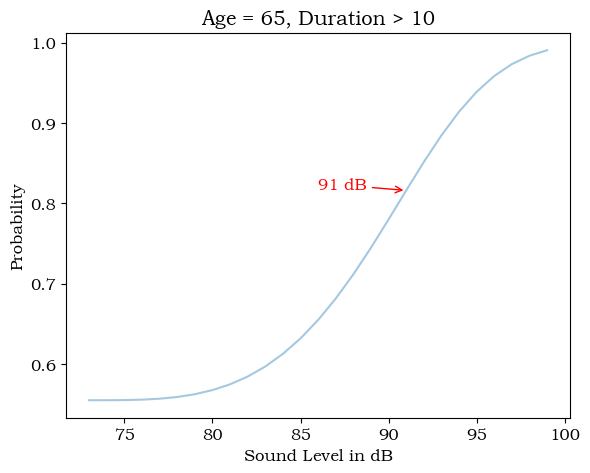

In [29]:
best_params_estimated = (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
best_L_control = 73
max_LAeq = 102

point_type = "1st"

udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)


udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)


udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)

2024-03-26 00:09:27.891 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:09:27.892 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:09:27.894 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
C:\Users\Liuhe\AppData\Local\Temp\ipykernel_66048\674183680.py:10: RuntimeWarning: invalid value encountered in power
  beta21 * np.power(x[:, 1], phi) + \
2024-03-26 00:09:27.896 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 9.49166508e-06 3.67903929e-05 9.08271532e-05 1.76871842e-04
 2.99495068e-04 4.63241462e-04 6.73107633e-04 9.35001944e-04
 1.25624756e-03 1.64616990e-03 2.11680953e-03 2.68380893e-03
 3.36753293e-03 4.19449479e-03 5.19917037e-03 6.42628182e-03
 7.93360456e-03 9.79526229e-03 1.21052615e-02 1.49805657e-02
 1.85621338e-02 2.30107865e-02 2.84922680e-02 3.51425507e-02
 4.30016993e-02 4.72298474e-02]
2024-03-26 00:09:27.897 | INFO    

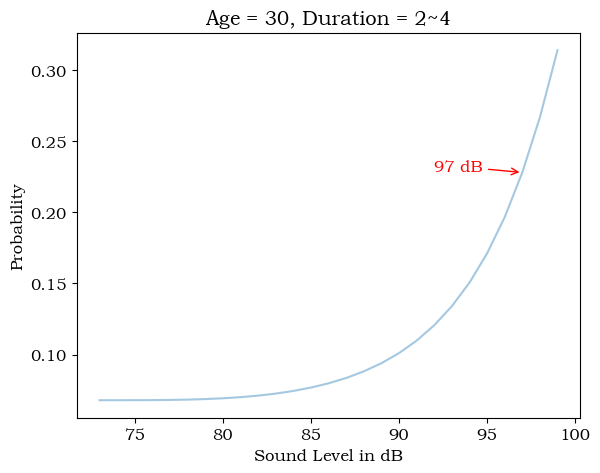

2024-03-26 00:09:28.006 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:09:28.007 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:09:28.007 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
C:\Users\Liuhe\AppData\Local\Temp\ipykernel_66048\674183680.py:11: RuntimeWarning: invalid value encountered in power
  beta22 * np.power(x[:, 2], phi) + \
2024-03-26 00:09:28.008 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 1.42065395e-05 5.50764570e-05 1.36036907e-04 2.65165957e-04
 4.49752247e-04 6.97477763e-04 1.01736577e-03 1.42077754e-03
 1.92258011e-03 2.54259162e-03 3.30742949e-03 4.25291790e-03
 5.42724615e-03 6.89508970e-03 8.74287267e-03 1.10851776e-02
 1.40718127e-02 1.78938750e-02 2.27846712e-02 2.90066839e-02
 3.68081705e-02 4.63238753e-02 5.73922512e-02 6.92897374e-02
 8.04761471e-02 8.56415019e-02]
2024-03-26 00:09:28.008 | INFO    

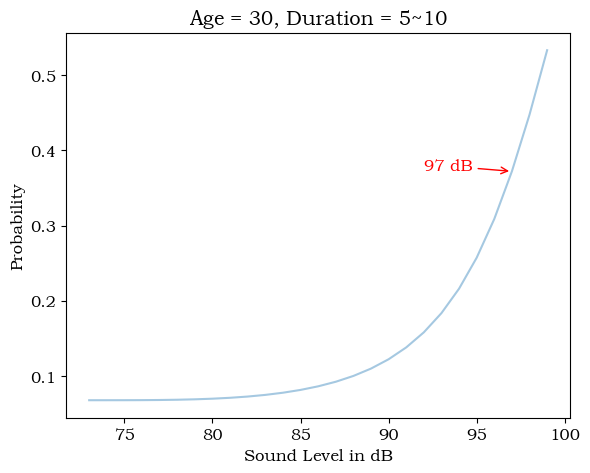

2024-03-26 00:09:28.130 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:09:28.130 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:09:28.131 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
C:\Users\Liuhe\AppData\Local\Temp\ipykernel_66048\674183680.py:12: RuntimeWarning: invalid value encountered in power
  beta23 * np.power(x[:, 3], phi)
2024-03-26 00:09:28.132 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 2.28692142e-05 8.86923821e-05 2.19261250e-04 4.28144790e-04
 7.28410949e-04 1.13507124e-03 1.66735369e-03 2.35135068e-03
 3.22338348e-03 4.33447079e-03 5.75639625e-03 7.58997691e-03
 9.97613386e-03 1.31099843e-02 1.72567673e-02 2.27645706e-02
 3.00598667e-02 3.95939809e-02 5.16807613e-02 6.61452245e-02
 8.17591775e-02 9.57031626e-02 1.03762696e-01 1.02033522e-01
 8.96010180e-02 8.08675566e-02]
2024-03-26 00:09:28.132 | INFO     | _

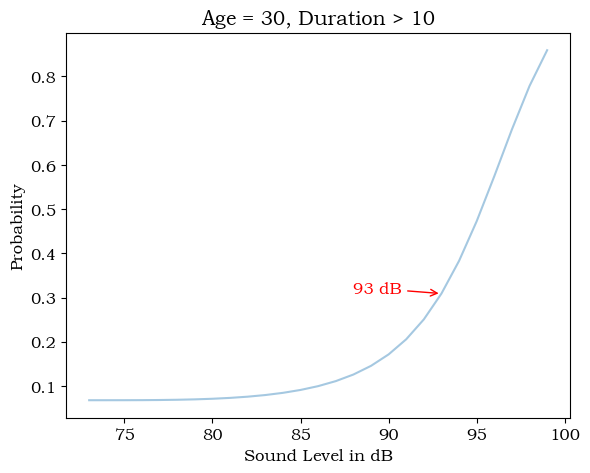

2024-03-26 00:09:28.239 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:09:28.240 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:09:28.240 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:09:28.241 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 2.37789947e-05 9.21581447e-05 2.27451213e-04 4.42667714e-04
 7.48803806e-04 1.15634878e-03 1.67623852e-03 2.32067521e-03
 3.10392621e-03 4.04314004e-03 5.15918374e-03 6.47747497e-03
 8.02874014e-03 9.84956178e-03 1.19824685e-02 1.44751496e-02
 1.73781254e-02 2.07398647e-02 2.45979554e-02 2.89646458e-02
 3.38052325e-02 3.90090489e-02 4.43561459e-02 4.94889412e-02
 5.39063525e-02 5.58649472e-02]
2024-03-26 00:09:28.241 | INFO     | __main__:udlr_res_plot:41 - f prime double: [       nan        nan        nan        nan        nan 0.00010184
 0.00017525 0.00026068 0.00035684 0.000463

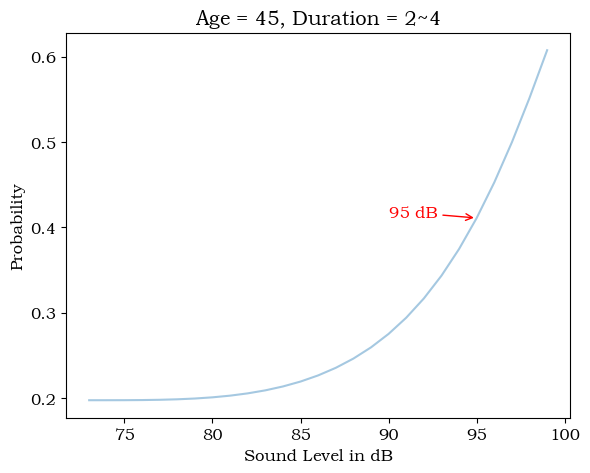

2024-03-26 00:09:28.333 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:09:28.333 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:09:28.334 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:09:28.335 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 3.55902464e-05 1.37953003e-04 3.40590158e-04 6.63305016e-04
 1.12332985e-03 1.73786547e-03 2.52585866e-03 3.50964024e-03
 4.71658069e-03 6.18078945e-03 7.94479087e-03 1.00609812e-02
 1.25924531e-02 1.56124069e-02 1.92007789e-02 2.34358561e-02
 2.83775844e-02 3.40384139e-02 4.03380151e-02 4.70423500e-02
 5.36986642e-02 5.95975231e-02 6.38141764e-02 6.53814022e-02
 6.35930732e-02 6.17992559e-02]
2024-03-26 00:09:28.335 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan  0.0001525
  0.00026268  0.00039137  0.00053728 

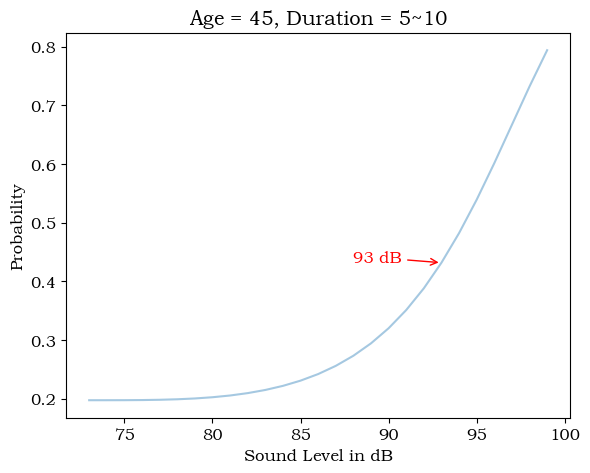

2024-03-26 00:09:28.439 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:09:28.439 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:09:28.440 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:09:28.441 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 5.72899596e-05 2.22120554e-04 5.48729596e-04 1.06997618e-03
 1.81589004e-03 2.81860337e-03 4.11624651e-03 5.75677663e-03
 7.80189479e-03 1.03308374e-02 1.34433329e-02 1.72601231e-02
 2.19178663e-02 2.75526807e-02 3.42631456e-02 4.20407214e-02
 5.06581890e-02 5.95252525e-02 6.75675421e-02 7.32550723e-02
 7.49350032e-02 7.14906541e-02 6.30287506e-02 5.10698004e-02
 3.79749083e-02 3.14614883e-02]
2024-03-26 00:09:28.442 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan  0.00024572
  0.00042393  0.00063358  0.00087431

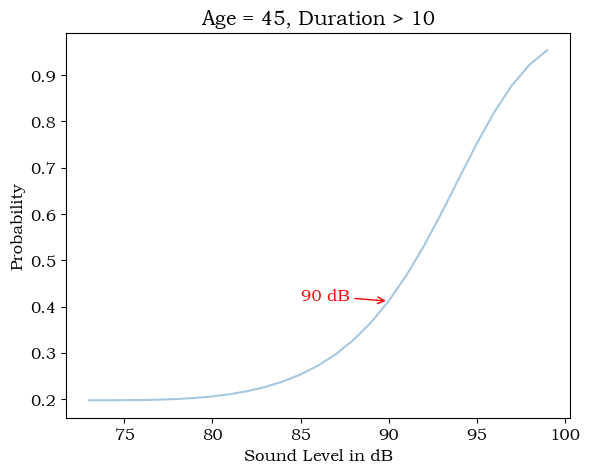

2024-03-26 00:09:28.564 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:09:28.565 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:09:28.565 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:09:28.566 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 3.70376385e-05 1.43496289e-04 3.53871672e-04 6.87602653e-04
 1.15988798e-03 1.78330760e-03 2.56838835e-03 3.52374323e-03
 4.65592173e-03 5.96898233e-03 7.46374444e-03 9.13665036e-03
 1.09781615e-02 1.29706350e-02 1.50856896e-02 1.72811978e-02
 1.94982473e-02 2.16587153e-02 2.36644506e-02 2.53993775e-02
 2.67359225e-02 2.75467585e-02 2.77217250e-02 2.71879061e-02
 2.59286986e-02 2.51197312e-02]
2024-03-26 00:09:28.566 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan  0.00015842
  0.00027205  0.00040301  0.00054785

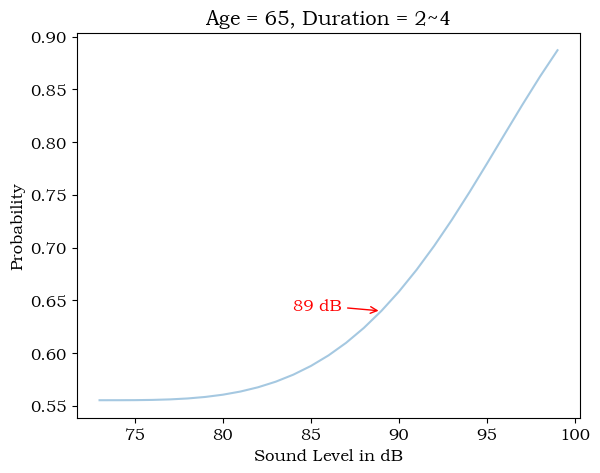

2024-03-26 00:09:28.667 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:09:28.668 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:09:28.668 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:09:28.669 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 5.54316288e-05 2.14755348e-04 5.29568158e-04 1.02886431e-03
 1.73514973e-03 2.66674682e-03 3.83843946e-03 5.26134571e-03
 6.94214619e-03 8.88158560e-03 1.10720766e-02 1.34942213e-02
 1.61121460e-02 1.88677820e-02 2.16746835e-02 2.44127126e-02
 2.69258874e-02 2.90266080e-02 3.05097402e-02 3.11787303e-02
 3.08823082e-02 2.95547058e-02 2.72469009e-02 2.41349983e-02
 2.04975037e-02 1.85873485e-02]
2024-03-26 00:09:28.669 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan  0.00023707
  0.00040705  0.00060279  0.00081894

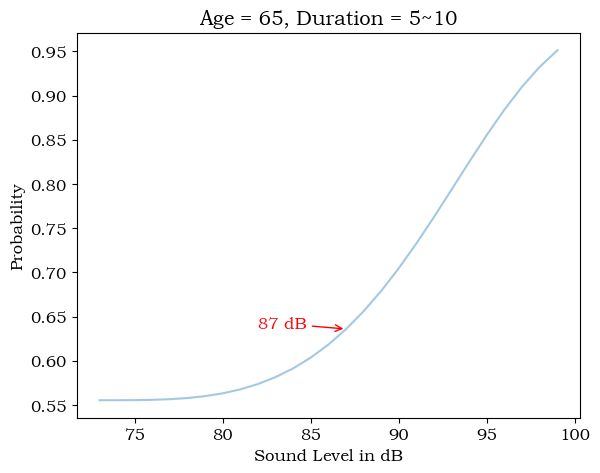

2024-03-26 00:09:28.772 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:09:28.772 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:09:28.773 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:09:28.774 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 8.92200841e-05 3.45643702e-04 8.52228432e-04 1.65534407e-03
 2.79046835e-03 4.28546951e-03 6.16088193e-03 8.42836456e-03
 1.10872244e-02 1.41185181e-02 1.74762218e-02 2.10753752e-02
 2.47782227e-02 2.83814960e-02 3.16110605e-02 3.41332530e-02
 3.55928096e-02 3.56815187e-02 3.42272436e-02 3.12737955e-02
 2.71113874e-02 2.22298153e-02 1.72024762e-02 1.25469168e-02
 8.61874426e-03 6.86845299e-03]
2024-03-26 00:09:28.775 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan  0.0003815
  0.00065485  0.00096912  0.00131506 

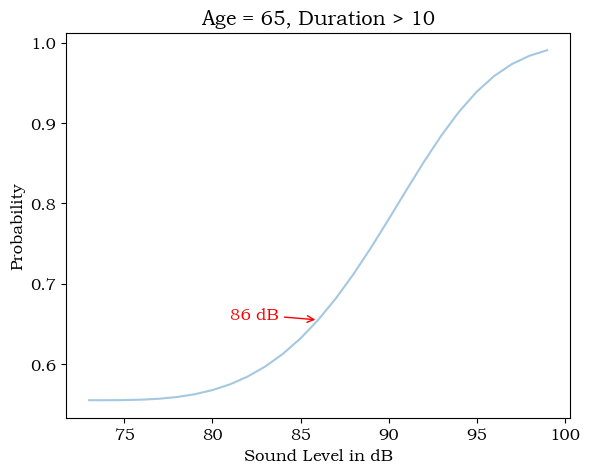

In [30]:
best_params_estimated = (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
best_L_control = 73
max_LAeq = 102

point_type = "2nd"

udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)


udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)


udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)

2024-03-26 00:04:03.010 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:04:03.010 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:04:03.011 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
C:\Users\Liuhe\AppData\Local\Temp\ipykernel_66048\674183680.py:10: RuntimeWarning: invalid value encountered in power
  beta21 * np.power(x[:, 1], phi) + \
2024-03-26 00:04:03.012 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 9.49166508e-06 3.67903929e-05 9.08271532e-05 1.76871842e-04
 2.99495068e-04 4.63241462e-04 6.73107633e-04 9.35001944e-04
 1.25624756e-03 1.64616990e-03 2.11680953e-03 2.68380893e-03
 3.36753293e-03 4.19449479e-03 5.19917037e-03 6.42628182e-03
 7.93360456e-03 9.79526229e-03 1.21052615e-02 1.49805657e-02
 1.85621338e-02 2.30107865e-02 2.84922680e-02 3.51425507e-02
 4.30016993e-02 4.72298474e-02]
2024-03-26 00:04:03.013 | INFO    

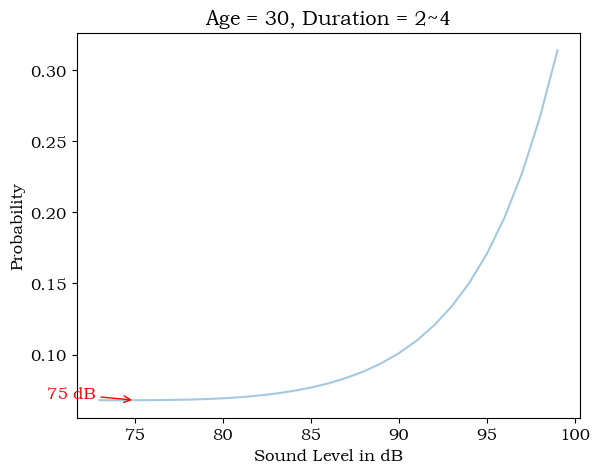

2024-03-26 00:04:03.122 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:04:03.123 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:04:03.123 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
C:\Users\Liuhe\AppData\Local\Temp\ipykernel_66048\674183680.py:11: RuntimeWarning: invalid value encountered in power
  beta22 * np.power(x[:, 2], phi) + \
2024-03-26 00:04:03.125 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 1.42065395e-05 5.50764570e-05 1.36036907e-04 2.65165957e-04
 4.49752247e-04 6.97477763e-04 1.01736577e-03 1.42077754e-03
 1.92258011e-03 2.54259162e-03 3.30742949e-03 4.25291790e-03
 5.42724615e-03 6.89508970e-03 8.74287267e-03 1.10851776e-02
 1.40718127e-02 1.78938750e-02 2.27846712e-02 2.90066839e-02
 3.68081705e-02 4.63238753e-02 5.73922512e-02 6.92897374e-02
 8.04761471e-02 8.56415019e-02]
2024-03-26 00:04:03.126 | INFO    

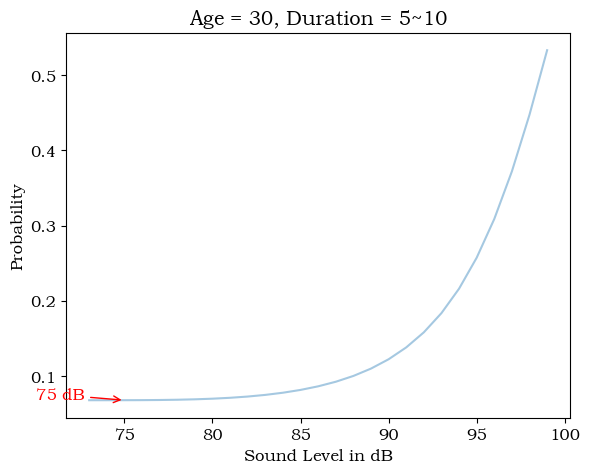

2024-03-26 00:04:03.253 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:04:03.253 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:04:03.254 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
C:\Users\Liuhe\AppData\Local\Temp\ipykernel_66048\674183680.py:12: RuntimeWarning: invalid value encountered in power
  beta23 * np.power(x[:, 3], phi)
2024-03-26 00:04:03.255 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 2.28692142e-05 8.86923821e-05 2.19261250e-04 4.28144790e-04
 7.28410949e-04 1.13507124e-03 1.66735369e-03 2.35135068e-03
 3.22338348e-03 4.33447079e-03 5.75639625e-03 7.58997691e-03
 9.97613386e-03 1.31099843e-02 1.72567673e-02 2.27645706e-02
 3.00598667e-02 3.95939809e-02 5.16807613e-02 6.61452245e-02
 8.17591775e-02 9.57031626e-02 1.03762696e-01 1.02033522e-01
 8.96010180e-02 8.08675566e-02]
2024-03-26 00:04:03.256 | INFO     | _

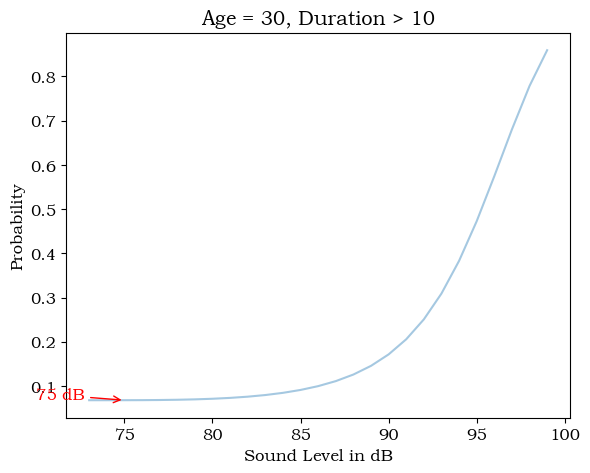

2024-03-26 00:04:03.364 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:04:03.364 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:04:03.365 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:04:03.366 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 2.37789947e-05 9.21581447e-05 2.27451213e-04 4.42667714e-04
 7.48803806e-04 1.15634878e-03 1.67623852e-03 2.32067521e-03
 3.10392621e-03 4.04314004e-03 5.15918374e-03 6.47747497e-03
 8.02874014e-03 9.84956178e-03 1.19824685e-02 1.44751496e-02
 1.73781254e-02 2.07398647e-02 2.45979554e-02 2.89646458e-02
 3.38052325e-02 3.90090489e-02 4.43561459e-02 4.94889412e-02
 5.39063525e-02 5.58649472e-02]
2024-03-26 00:04:03.366 | INFO     | __main__:udlr_res_plot:41 - f prime double: [       nan        nan        nan        nan        nan 0.00010184
 0.00017525 0.00026068 0.00035684 0.000463

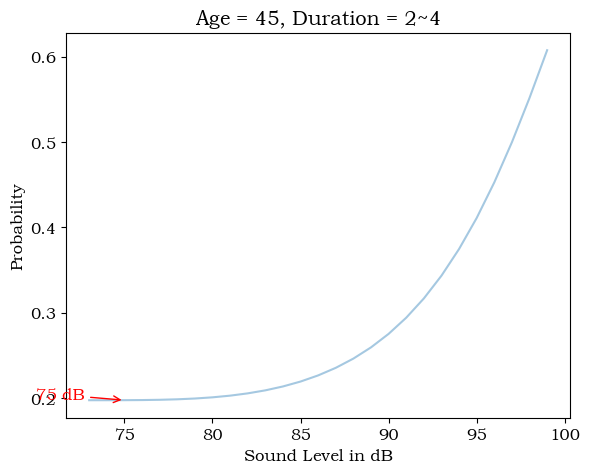

2024-03-26 00:04:03.464 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:04:03.464 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:04:03.464 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:04:03.465 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 3.55902464e-05 1.37953003e-04 3.40590158e-04 6.63305016e-04
 1.12332985e-03 1.73786547e-03 2.52585866e-03 3.50964024e-03
 4.71658069e-03 6.18078945e-03 7.94479087e-03 1.00609812e-02
 1.25924531e-02 1.56124069e-02 1.92007789e-02 2.34358561e-02
 2.83775844e-02 3.40384139e-02 4.03380151e-02 4.70423500e-02
 5.36986642e-02 5.95975231e-02 6.38141764e-02 6.53814022e-02
 6.35930732e-02 6.17992559e-02]
2024-03-26 00:04:03.466 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan  0.0001525
  0.00026268  0.00039137  0.00053728 

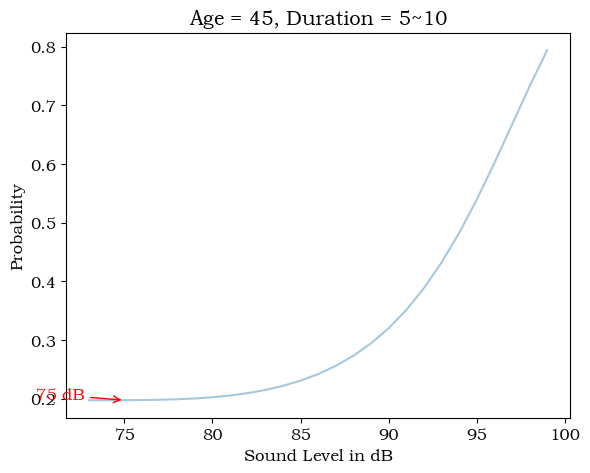

2024-03-26 00:04:03.561 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:04:03.561 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:04:03.562 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:04:03.563 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 5.72899596e-05 2.22120554e-04 5.48729596e-04 1.06997618e-03
 1.81589004e-03 2.81860337e-03 4.11624651e-03 5.75677663e-03
 7.80189479e-03 1.03308374e-02 1.34433329e-02 1.72601231e-02
 2.19178663e-02 2.75526807e-02 3.42631456e-02 4.20407214e-02
 5.06581890e-02 5.95252525e-02 6.75675421e-02 7.32550723e-02
 7.49350032e-02 7.14906541e-02 6.30287506e-02 5.10698004e-02
 3.79749083e-02 3.14614883e-02]
2024-03-26 00:04:03.563 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan  0.00024572
  0.00042393  0.00063358  0.00087431

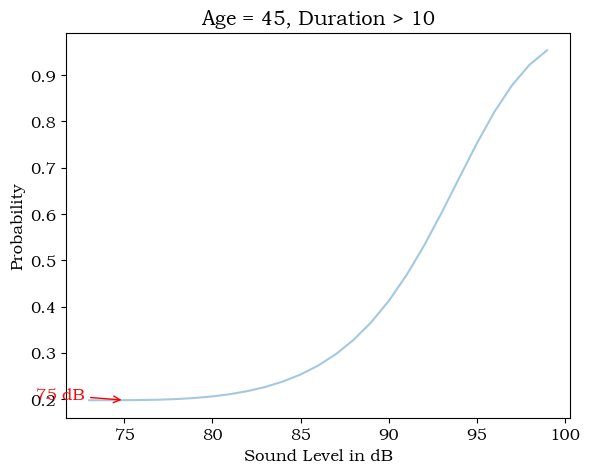

2024-03-26 00:04:03.759 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:04:03.760 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:04:03.760 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:04:03.761 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 3.70376385e-05 1.43496289e-04 3.53871672e-04 6.87602653e-04
 1.15988798e-03 1.78330760e-03 2.56838835e-03 3.52374323e-03
 4.65592173e-03 5.96898233e-03 7.46374444e-03 9.13665036e-03
 1.09781615e-02 1.29706350e-02 1.50856896e-02 1.72811978e-02
 1.94982473e-02 2.16587153e-02 2.36644506e-02 2.53993775e-02
 2.67359225e-02 2.75467585e-02 2.77217250e-02 2.71879061e-02
 2.59286986e-02 2.51197312e-02]
2024-03-26 00:04:03.762 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan  0.00015842
  0.00027205  0.00040301  0.00054785

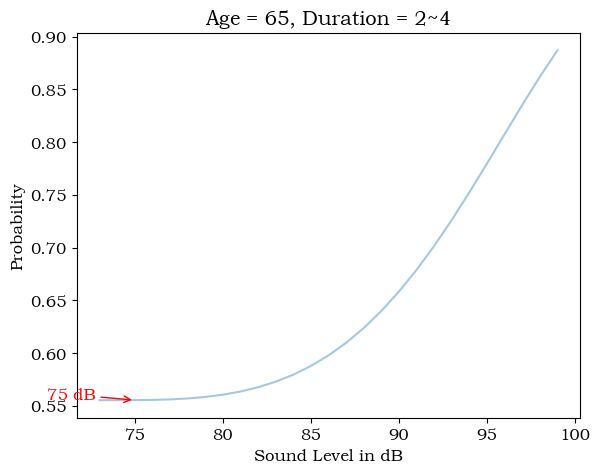

2024-03-26 00:04:03.859 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:04:03.859 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:04:03.860 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:04:03.860 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 5.54316288e-05 2.14755348e-04 5.29568158e-04 1.02886431e-03
 1.73514973e-03 2.66674682e-03 3.83843946e-03 5.26134571e-03
 6.94214619e-03 8.88158560e-03 1.10720766e-02 1.34942213e-02
 1.61121460e-02 1.88677820e-02 2.16746835e-02 2.44127126e-02
 2.69258874e-02 2.90266080e-02 3.05097402e-02 3.11787303e-02
 3.08823082e-02 2.95547058e-02 2.72469009e-02 2.41349983e-02
 2.04975037e-02 1.85873485e-02]
2024-03-26 00:04:03.861 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan  0.00023707
  0.00040705  0.00060279  0.00081894

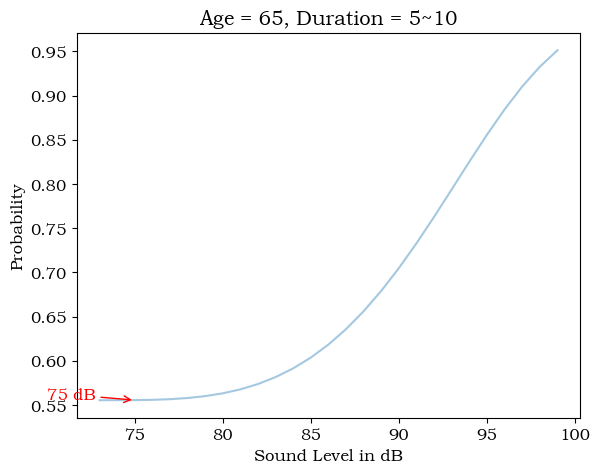

2024-03-26 00:04:03.976 | INFO     | __main__:udlr_res_plot:27 - Params: (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
2024-03-26 00:04:03.976 | INFO     | __main__:udlr_res_plot:28 - L_control: 73
2024-03-26 00:04:03.977 | INFO     | __main__:udlr_res_plot:29 - max LAeq: 102
2024-03-26 00:04:03.978 | INFO     | __main__:udlr_res_plot:40 - f prime: [           nan            nan            nan            nan
 8.92200841e-05 3.45643702e-04 8.52228432e-04 1.65534407e-03
 2.79046835e-03 4.28546951e-03 6.16088193e-03 8.42836456e-03
 1.10872244e-02 1.41185181e-02 1.74762218e-02 2.10753752e-02
 2.47782227e-02 2.83814960e-02 3.16110605e-02 3.41332530e-02
 3.55928096e-02 3.56815187e-02 3.42272436e-02 3.12737955e-02
 2.71113874e-02 2.22298153e-02 1.72024762e-02 1.25469168e-02
 8.61874426e-03 6.86845299e-03]
2024-03-26 00:04:03.978 | INFO     | __main__:udlr_res_plot:41 - f prime double: [        nan         nan         nan         nan         nan  0.0003815
  0.00065485  0.00096912  0.00131506 

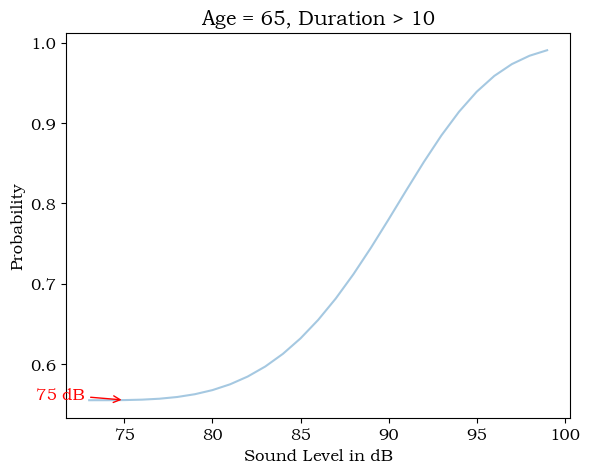

In [28]:
best_params_estimated = (-5.0557, 0.0812, 2.6653, 3.989, 6.4206, 3.4)
best_L_control = 73
max_LAeq = 102

point_type = "2nd_critical"

udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=30,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)


udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=45,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)


udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([1,0,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([0,1,0]),
              point_type=point_type)
udlr_res_plot(best_params_estimated=best_params_estimated,
              best_L_control=best_L_control,
              max_LAeq=max_LAeq,
              age=65,
              LAeq=np.arange(70,100),
              duration=np.array([0,0,1]),
              point_type=point_type)

### 模型预测概率获取

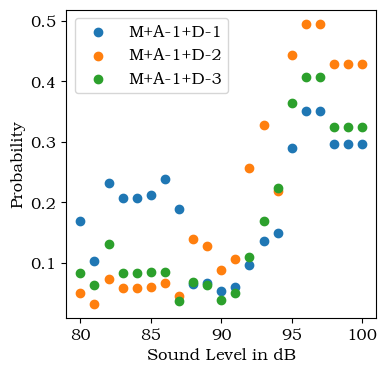

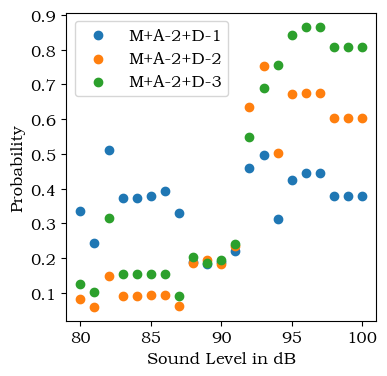

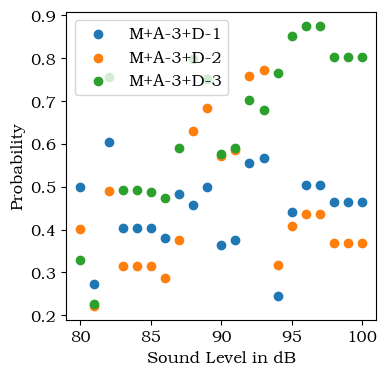

In [8]:
# Step 1
## 加载NOISH的预测模型
NOISH_predict_model = pickle.load(open(models_path / f"NOISH_experiment_group_catboost-{key_feature}_classifier_model.pkl", "rb"))

## 获取不同分组中，随LAeq变化NIHL确诊概率的变化情况
for sex in ("M"):
    for age_box in ("A-1","A-2","A-3"):
        fig, ax = plt.subplots(1, figsize=(4,4))
        for duration_box in ("D-1","D-2","D-3"):
            LAeq = np.arange(80, 101)
            X = np.stack([LAeq, [sex]*len(LAeq), [age_box]*len(LAeq), [duration_box]*len(LAeq)], axis=1)
            prob = NOISH_predict_model.predict_proba(X)[:,1]
            ax.scatter(LAeq, prob, label=f"{sex}+{age_box}+{duration_box}")
        ax.set_ylabel("Probability")
        ax.set_xlabel("Sound Level in dB")
        plt.legend(loc="best")
        plt.show()

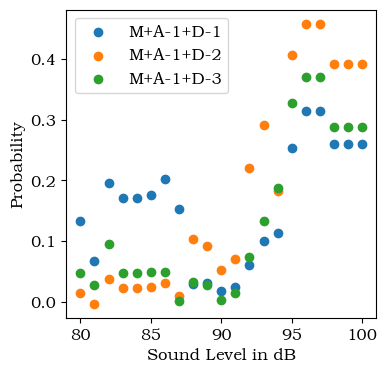

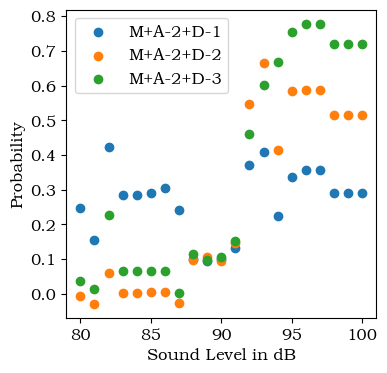

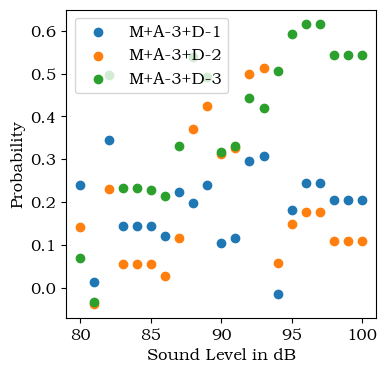

In [14]:
## 获取不同分组中，随LAeq变化NIHL确诊超额概率（减去对照组概率）的变化情况
for sex in ("M"):
    for age_box in ("A-1","A-2","A-3"):
        fig, ax = plt.subplots(1, figsize=(4,4))
        for duration_box, color in zip(("D-1","D-2","D-3"), ('#1f77b4', '#ff7f0e', '#2ca02c')):
            LAeq = np.arange(80, 101)
            X = np.stack([LAeq, [sex]*len(LAeq), [age_box]*len(LAeq), [duration_box]*len(LAeq)], axis=1)
            prob = NOISH_predict_model.predict_proba(X)[:,1]
            control_prob = float(NOISH_control_group_base_prob.loc[sex, age_box])
            # logger.info(f"predict prob: {prob}")
            # logger.info(f"risk prob: {prob - control_prob}")
            # ax.scatter(LAeq, prob, marker="*", color=color, label=f"{sex}+{age_box}+{duration_box}")
            ax.scatter(LAeq, prob-control_prob, marker="o", color=color, label=f"{sex}+{age_box}+{duration_box}")
        ax.set_ylabel("Probability")
        ax.set_xlabel("Sound Level in dB")
        plt.legend(loc="best")
        plt.show()

### 模型预测概率拟合

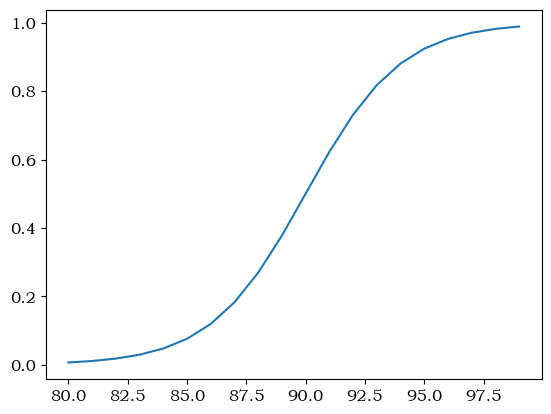

In [76]:
def logistic_pdf(x, miu, gamma):
    return 1 / (1 + np.exp((miu-x)/gamma))

x = np.arange(80, 100)
plt.plot(x, logistic_pdf(x, 90, 2))
plt.show()

2024-03-19 16:16:14.600 | INFO     | __main__:<module>:13 - curve fit parameters: [115.34516136  14.43827394]
2024-03-19 16:16:14.602 | INFO     | __main__:<module>:13 - curve fit parameters: [99.79362447  5.16157911]
2024-03-19 16:16:14.606 | INFO     | __main__:<module>:13 - curve fit parameters: [102.60399056   5.50498325]


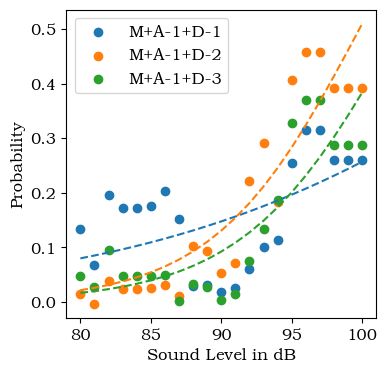

2024-03-19 16:16:14.700 | INFO     | __main__:<module>:13 - curve fit parameters: [147.22345077  56.30417947]
2024-03-19 16:16:14.702 | INFO     | __main__:<module>:13 - curve fit parameters: [95.96930597  4.56257649]
2024-03-19 16:16:14.707 | INFO     | __main__:<module>:13 - curve fit parameters: [93.37796948  2.89557704]


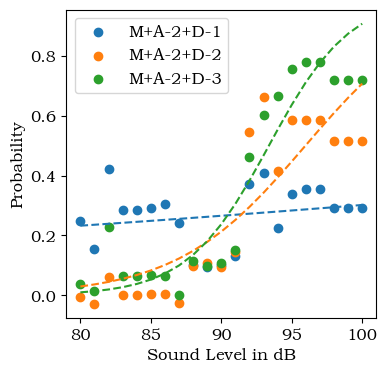

2024-03-19 16:16:14.802 | INFO     | __main__:<module>:13 - curve fit parameters: [197.99851534  72.98631062]
2024-03-19 16:16:14.805 | INFO     | __main__:<module>:13 - curve fit parameters: [153.36231557  43.48106861]
2024-03-19 16:16:14.807 | INFO     | __main__:<module>:13 - curve fit parameters: [94.5233822   9.87971674]


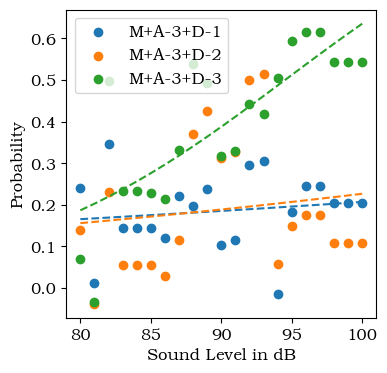

In [94]:
initial_guess = [90, 10]
## 获取不同分组中，使用S曲线拟合随LAeq变化NIHL确诊超额概率（减去对照组概率）的变化情况
for sex in ("M"):
    for age_box in ("A-1","A-2","A-3"):
        fig, ax = plt.subplots(1, figsize=(4,4))
        for duration_box, color in zip(("D-1","D-2","D-3"), ('#1f77b4', '#ff7f0e', '#2ca02c')):
            LAeq = np.arange(80, 101)
            X = np.stack([LAeq, [sex]*len(LAeq), [age_box]*len(LAeq), [duration_box]*len(LAeq)], axis=1)
            prob = NOISH_predict_model.predict_proba(X)[:,1]
            control_prob = float(NOISH_control_group_base_prob.loc[sex, age_box])
            excess_risk = prob - control_prob
            popt, pcov = curve_fit(logistic_pdf, LAeq, excess_risk, p0=initial_guess)
            logger.info(f"curve fit parameters: {popt}")
            ax.scatter(LAeq, excess_risk, marker="o", color=color, label=f"{sex}+{age_box}+{duration_box}")
            ax.plot(LAeq, logistic_pdf(LAeq, *popt), color=color, linestyle="--")
        ax.set_ylabel("Probability")
        ax.set_xlabel("Sound Level in dB")
        plt.legend(loc="best")
        plt.show()